In [446]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qv61m_gc
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-qv61m_gc
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620


In [18]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.11.0+cu102


In [19]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [20]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [21]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.nn as nn

### Calculating Entropy

In [22]:
def get_entropy(probs):
    for prob in probs:
        prob_val = prob.item()
        entropy = 0
        entropy += -(prob_val * np.log2(prob_val))
    return entropy

### Game 1 

In [23]:
parent = os.path.split(os.getcwd())[0]
fpath = os.path.join(parent, "data", "shapeworld", "reference-1000-0.npz")
fpath

'/data/pawanw/calibrate_your_listeners_clip/calibrate_your_listeners/data/shapeworld/reference-1000-0.npz'

In [24]:
batch = np.load(fpath)
imgs, labels, utterances = (batch['imgs'], batch['labels'].argmax(-1), batch['langs'])

In [25]:
lis_scores = []
entropies = []

for i in range(len(imgs)):
    states = batch['imgs'][i]

    original_images = []
    images = []
    # plt.figure(figsize=(16, 5))

    for j in range(3):
        image = Image.fromarray(np.uint8(states[j])).convert('RGB')
        # plt.subplot(2, 4, len(images) + 1)
        # plt.imshow(image)
        # plt.xticks([])
        # plt.yticks([])

        original_images.append(image)
        images.append(preprocess(image))

    # plt.tight_layout()
    
    image_input = torch.tensor(np.stack(images)).cuda()

    lang = batch['langs'][i]
    if lang[0] in ['a', 'e', 'i', 'o', 'u']:
        utterance = "This is an " + lang
    else:
        utterance = "This is a " + lang
    utterance_tokens = clip.tokenize(utterance).cuda()

    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        utterance_features = model.encode_text(utterance_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    utterance_features /= utterance_features.norm(dim=-1, keepdim=True)

    image_probs = (100.0 * utterance_features @ image_features.T).softmax(dim=-1)
    top_probs, top_labels = image_probs.cpu().topk(3, dim=-1)

    lis_scores.append(image_probs[0])
    
    entropy = get_entropy(image_probs[0])
    entropies.append(entropy)
    
    print(i)
    print("top_probs:  ",top_probs)
    print("top_labels: ", top_labels)
    print("image_probs:", image_probs)
    print("entropy:    ", entropy)

0
top_probs:   tensor([[0.9515, 0.0257, 0.0228]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9515, 0.0257, 0.0228]], device='cuda:0')
entropy:     0.12438580904457698
1
top_probs:   tensor([[0.9875, 0.0087, 0.0039]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9875, 0.0087, 0.0039]], device='cuda:0')
entropy:     0.030938071311854148
2
top_probs:   tensor([[0.5378, 0.3227, 0.1395]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5378, 0.3227, 0.1395]], device='cuda:0')
entropy:     0.396408992666446
3
top_probs:   tensor([[0.9905, 0.0053, 0.0043]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9905, 0.0053, 0.0043]], device='cuda:0')
entropy:     0.03358289950928185
4
top_probs:   tensor([[0.6512, 0.2587, 0.0902]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6512, 0.2587, 0.0902]], device='cuda:0')
entropy:     0.31304892892902625
5
top_probs:   tensor([[0.5009, 0.3639, 0.1352]])
top_labels:  tensor([[0, 2, 1]])
image_probs: 

47
top_probs:   tensor([[0.7555, 0.2244, 0.0200]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.7555, 0.2244, 0.0200]], device='cuda:0')
entropy:     0.11304931904587884
48
top_probs:   tensor([[0.6376, 0.2464, 0.1160]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.6376, 0.1160, 0.2464]], device='cuda:0')
entropy:     0.4979695830126923
49
top_probs:   tensor([[0.7931, 0.1636, 0.0433]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.7931, 0.0433, 0.1636]], device='cuda:0')
entropy:     0.42732652528713916
50
top_probs:   tensor([[9.9268e-01, 6.4054e-03, 9.1704e-04]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[9.9268e-01, 6.4054e-03, 9.1704e-04]], device='cuda:0')
entropy:     0.009253578676849374
51
top_probs:   tensor([[0.9527, 0.0360, 0.0113]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9527, 0.0113, 0.0360]], device='cuda:0')
entropy:     0.17275696188536188
52
top_probs:   tensor([[0.8960, 0.0938, 0.0101]])
top_labels:  te

93
top_probs:   tensor([[0.5347, 0.2329, 0.2325]])
top_labels:  tensor([[1, 2, 0]])
image_probs: tensor([[0.2325, 0.5347, 0.2329]], device='cuda:0')
entropy:     0.48959813631006294
94
top_probs:   tensor([[0.5026, 0.2735, 0.2240]])
top_labels:  tensor([[1, 2, 0]])
image_probs: tensor([[0.2240, 0.5026, 0.2735]], device='cuda:0')
entropy:     0.5115441835255122
95
top_probs:   tensor([[0.4359, 0.3295, 0.2345]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.4359, 0.3295, 0.2345]], device='cuda:0')
entropy:     0.49067987741274455
96
top_probs:   tensor([[0.5450, 0.3136, 0.1415]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5450, 0.3136, 0.1415]], device='cuda:0')
entropy:     0.3991290343539208
97
top_probs:   tensor([[0.9755, 0.0203, 0.0042]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9755, 0.0203, 0.0042]], device='cuda:0')
entropy:     0.03287470150644271
98
top_probs:   tensor([[0.5905, 0.2061, 0.2034]])
top_labels:  tensor([[0, 1, 2]])
image_pr

138
top_probs:   tensor([[0.9070, 0.0538, 0.0392]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9070, 0.0392, 0.0538]], device='cuda:0')
entropy:     0.2267540038966647
139
top_probs:   tensor([[0.9723, 0.0220, 0.0056]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9723, 0.0220, 0.0056]], device='cuda:0')
entropy:     0.04216774111220318
140
top_probs:   tensor([[0.8911, 0.0692, 0.0397]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.0692, 0.8911, 0.0397]], device='cuda:0')
entropy:     0.18480904036094306
141
top_probs:   tensor([[0.5819, 0.3748, 0.0433]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5819, 0.3748, 0.0433]], device='cuda:0')
entropy:     0.19610096914087427
142
top_probs:   tensor([[0.8293, 0.1030, 0.0677]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8293, 0.1030, 0.0677]], device='cuda:0')
entropy:     0.26290377015251826
143
top_probs:   tensor([[0.5611, 0.2447, 0.1942]])
top_labels:  tensor([[0, 2, 1]])
i

184
top_probs:   tensor([[0.9675, 0.0181, 0.0144]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9675, 0.0181, 0.0144]], device='cuda:0')
entropy:     0.08803620884666692
185
top_probs:   tensor([[0.4552, 0.3919, 0.1529]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.3919, 0.4552, 0.1529]], device='cuda:0')
entropy:     0.4142648272318559
186
top_probs:   tensor([[0.8967, 0.0749, 0.0284]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.8967, 0.0284, 0.0749]], device='cuda:0')
entropy:     0.2799763239609249
187
top_probs:   tensor([[0.5207, 0.4286, 0.0507]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.4286, 0.0507, 0.5207]], device='cuda:0')
entropy:     0.4902483573785805
188
top_probs:   tensor([[0.4547, 0.3375, 0.2078]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.4547, 0.2078, 0.3375]], device='cuda:0')
entropy:     0.528870166447165
189
top_probs:   tensor([[0.6407, 0.2741, 0.0852]])
top_labels:  tensor([[0, 2, 1]])
image

230
top_probs:   tensor([[0.8187, 0.1139, 0.0674]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.1139, 0.0674, 0.8187]], device='cuda:0')
entropy:     0.2362146183827553
231
top_probs:   tensor([[0.7764, 0.1477, 0.0759]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.7764, 0.0759, 0.1477]], device='cuda:0')
entropy:     0.4074924868485304
232
top_probs:   tensor([[0.4961, 0.3894, 0.1145]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.3894, 0.4961, 0.1145]], device='cuda:0')
entropy:     0.3580167150601195
233
top_probs:   tensor([[0.4776, 0.3409, 0.1815]])
top_labels:  tensor([[2, 1, 0]])
image_probs: tensor([[0.1815, 0.3409, 0.4776]], device='cuda:0')
entropy:     0.5091751014704611
234
top_probs:   tensor([[0.6635, 0.2338, 0.1027]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.6635, 0.1027, 0.2338]], device='cuda:0')
entropy:     0.49017922251625057
235
top_probs:   tensor([[0.4540, 0.4147, 0.1313]])
top_labels:  tensor([[1, 0, 2]])
imag

276
top_probs:   tensor([[0.4931, 0.3793, 0.1276]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.3793, 0.1276, 0.4931]], device='cuda:0')
entropy:     0.5029829258120226
277
top_probs:   tensor([[0.6560, 0.3131, 0.0309]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6560, 0.3131, 0.0309]], device='cuda:0')
entropy:     0.1550930731012991
278
top_probs:   tensor([[0.4838, 0.2929, 0.2232]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.4838, 0.2232, 0.2929]], device='cuda:0')
entropy:     0.5188877305699099
279
top_probs:   tensor([[0.5059, 0.2601, 0.2340]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.2601, 0.5059, 0.2340]], device='cuda:0')
entropy:     0.49034510802349895
280
top_probs:   tensor([[0.5488, 0.4392, 0.0120]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.5488, 0.0120, 0.4392]], device='cuda:0')
entropy:     0.5213650098605288
281
top_probs:   tensor([[0.3579, 0.3573, 0.2849]])
top_labels:  tensor([[0, 2, 1]])
imag

322
top_probs:   tensor([[0.5779, 0.3715, 0.0506]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5779, 0.3715, 0.0506]], device='cuda:0')
entropy:     0.21789908603739241
323
top_probs:   tensor([[0.6569, 0.2104, 0.1327]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.6569, 0.1327, 0.2104]], device='cuda:0')
entropy:     0.4731575520177458
324
top_probs:   tensor([[0.6920, 0.2130, 0.0949]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6920, 0.2130, 0.0949]], device='cuda:0')
entropy:     0.3224661381490371
325
top_probs:   tensor([[0.9805, 0.0164, 0.0031]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9805, 0.0031, 0.0164]], device='cuda:0')
entropy:     0.09718499315020894
326
top_probs:   tensor([[0.9905, 0.0069, 0.0026]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9905, 0.0069, 0.0026]], device='cuda:0')
entropy:     0.02231669299310402
327
top_probs:   tensor([[0.9712, 0.0152, 0.0136]])
top_labels:  tensor([[0, 1, 2]])
im

368
top_probs:   tensor([[0.4123, 0.3446, 0.2432]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.4123, 0.2432, 0.3446]], device='cuda:0')
entropy:     0.529647730582364
369
top_probs:   tensor([[0.5435, 0.3499, 0.1066]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5435, 0.3499, 0.1066]], device='cuda:0')
entropy:     0.34423073944073007
370
top_probs:   tensor([[0.9029, 0.0769, 0.0202]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.0769, 0.9029, 0.0202]], device='cuda:0')
entropy:     0.11373739104348164
371
top_probs:   tensor([[0.7337, 0.2531, 0.0132]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.7337, 0.2531, 0.0132]], device='cuda:0')
entropy:     0.08256636664632161
372
top_probs:   tensor([[0.4286, 0.3838, 0.1876]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.3838, 0.4286, 0.1876]], device='cuda:0')
entropy:     0.45295717220362147
373
top_probs:   tensor([[0.9895, 0.0062, 0.0043]])
top_labels:  tensor([[0, 1, 2]])
im

414
top_probs:   tensor([[0.7618, 0.1252, 0.1130]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.7618, 0.1252, 0.1130]], device='cuda:0')
entropy:     0.35543415005270973
415
top_probs:   tensor([[0.9846, 0.0107, 0.0046]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9846, 0.0046, 0.0107]], device='cuda:0')
entropy:     0.07028665927671761
416
top_probs:   tensor([[0.5483, 0.3057, 0.1460]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.3057, 0.1460, 0.5483]], device='cuda:0')
entropy:     0.47537960834144094
417
top_probs:   tensor([[0.8330, 0.0928, 0.0742]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8330, 0.0928, 0.0742]], device='cuda:0')
entropy:     0.27849044085699415
418
top_probs:   tensor([[0.9875, 0.0064, 0.0061]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9875, 0.0064, 0.0061]], device='cuda:0')
entropy:     0.044803405937511566
419
top_probs:   tensor([[0.8232, 0.0895, 0.0873]])
top_labels:  tensor([[0, 2, 1]])

460
top_probs:   tensor([[0.9830, 0.0118, 0.0052]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9830, 0.0118, 0.0052]], device='cuda:0')
entropy:     0.039513577195969755
461
top_probs:   tensor([[0.6741, 0.2481, 0.0778]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6741, 0.2481, 0.0778]], device='cuda:0')
entropy:     0.28669073347640656
462
top_probs:   tensor([[0.4304, 0.3155, 0.2541]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.3155, 0.4304, 0.2541]], device='cuda:0')
entropy:     0.5022266195170241
463
top_probs:   tensor([[0.7862, 0.1317, 0.0821]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.7862, 0.0821, 0.1317]], device='cuda:0')
entropy:     0.38519602044818557
464
top_probs:   tensor([[0.5650, 0.3425, 0.0924]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5650, 0.3425, 0.0924]], device='cuda:0')
entropy:     0.31758204838018156
465
top_probs:   tensor([[0.6238, 0.3713, 0.0049]])
top_labels:  tensor([[0, 2, 1]])


506
top_probs:   tensor([[0.9817, 0.0101, 0.0082]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9817, 0.0082, 0.0101]], device='cuda:0')
entropy:     0.06712555222273398
507
top_probs:   tensor([[0.6379, 0.2772, 0.0849]])
top_labels:  tensor([[1, 2, 0]])
image_probs: tensor([[0.0849, 0.6379, 0.2772]], device='cuda:0')
entropy:     0.5131161350631621
508
top_probs:   tensor([[0.3630, 0.3325, 0.3045]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.3630, 0.3325, 0.3045]], device='cuda:0')
entropy:     0.5223620596425815
509
top_probs:   tensor([[0.6291, 0.3030, 0.0679]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.6291, 0.0679, 0.3030]], device='cuda:0')
entropy:     0.5219457325084469
510
top_probs:   tensor([[0.7853, 0.1398, 0.0749]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.7853, 0.0749, 0.1398]], device='cuda:0')
entropy:     0.39683361893585883
511
top_probs:   tensor([[0.5456, 0.3700, 0.0844]])
top_labels:  tensor([[2, 0, 1]])
ima

552
top_probs:   tensor([[0.9890, 0.0075, 0.0035]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9890, 0.0075, 0.0035]], device='cuda:0')
entropy:     0.02836120253947701
553
top_probs:   tensor([[0.8252, 0.0949, 0.0799]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.8252, 0.0799, 0.0949]], device='cuda:0')
entropy:     0.32246915230885886
554
top_probs:   tensor([[0.9825, 0.0119, 0.0056]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9825, 0.0056, 0.0119]], device='cuda:0')
entropy:     0.07605069343597891
555
top_probs:   tensor([[0.5055, 0.4373, 0.0572]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.4373, 0.0572, 0.5055]], device='cuda:0')
entropy:     0.4975263045583743
556
top_probs:   tensor([[0.4861, 0.4022, 0.1117]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.4022, 0.4861, 0.1117]], device='cuda:0')
entropy:     0.35318695019830687
557
top_probs:   tensor([[0.5355, 0.3994, 0.0651]])
top_labels:  tensor([[0, 2, 1]])
i

598
top_probs:   tensor([[0.4240, 0.3086, 0.2674]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.4240, 0.2674, 0.3086]], device='cuda:0')
entropy:     0.5234329473547047
599
top_probs:   tensor([[0.5536, 0.2584, 0.1880]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.5536, 0.1880, 0.2584]], device='cuda:0')
entropy:     0.5044775168376657
600
top_probs:   tensor([[0.9635, 0.0239, 0.0126]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9635, 0.0239, 0.0126]], device='cuda:0')
entropy:     0.07929048481777709
601
top_probs:   tensor([[0.5597, 0.2652, 0.1751]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5597, 0.2652, 0.1751]], device='cuda:0')
entropy:     0.4401865264562403
602
top_probs:   tensor([[0.6810, 0.1612, 0.1577]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6810, 0.1612, 0.1577]], device='cuda:0')
entropy:     0.420263824235144
603
top_probs:   tensor([[0.5010, 0.4263, 0.0727]])
top_labels:  tensor([[2, 0, 1]])
image

644
top_probs:   tensor([[0.5296, 0.2564, 0.2140]])
top_labels:  tensor([[1, 2, 0]])
image_probs: tensor([[0.2140, 0.5296, 0.2564]], device='cuda:0')
entropy:     0.5034416859296946
645
top_probs:   tensor([[0.8103, 0.1310, 0.0587]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.8103, 0.0587, 0.1310]], device='cuda:0')
entropy:     0.3841226749992241
646
top_probs:   tensor([[0.6179, 0.3302, 0.0518]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.3302, 0.6179, 0.0518]], device='cuda:0')
entropy:     0.2212966658756286
647
top_probs:   tensor([[0.4712, 0.2739, 0.2549]])
top_labels:  tensor([[2, 1, 0]])
image_probs: tensor([[0.2549, 0.2739, 0.4712]], device='cuda:0')
entropy:     0.5115434941630175
648
top_probs:   tensor([[0.7614, 0.1748, 0.0638]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.7614, 0.0638, 0.1748]], device='cuda:0')
entropy:     0.4398549047145366
649
top_probs:   tensor([[0.4592, 0.4531, 0.0878]])
top_labels:  tensor([[0, 2, 1]])
image

690
top_probs:   tensor([[0.6528, 0.2139, 0.1333]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6528, 0.2139, 0.1333]], device='cuda:0')
entropy:     0.38758897926641467
691
top_probs:   tensor([[0.8022, 0.1430, 0.0548]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.8022, 0.0548, 0.1430]], device='cuda:0')
entropy:     0.4012659949242526
692
top_probs:   tensor([[0.8016, 0.1689, 0.0296]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8016, 0.1689, 0.0296]], device='cuda:0')
entropy:     0.15015643666815676
693
top_probs:   tensor([[0.6147, 0.2106, 0.1746]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.6147, 0.1746, 0.2106]], device='cuda:0')
entropy:     0.47334103640065944
694
top_probs:   tensor([[0.8970, 0.0559, 0.0471]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.8970, 0.0471, 0.0559]], device='cuda:0')
entropy:     0.23270443375080369
695
top_probs:   tensor([[0.9952, 0.0024, 0.0024]])
top_labels:  tensor([[0, 2, 1]])
i

736
top_probs:   tensor([[0.5241, 0.2435, 0.2324]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5241, 0.2435, 0.2324]], device='cuda:0')
entropy:     0.4893088605781854
737
top_probs:   tensor([[0.9873, 0.0064, 0.0063]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9873, 0.0064, 0.0063]], device='cuda:0')
entropy:     0.04602473889215531
738
top_probs:   tensor([[0.4472, 0.3697, 0.1831]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.4472, 0.1831, 0.3697]], device='cuda:0')
entropy:     0.5307311738106568
739
top_probs:   tensor([[0.9959, 0.0022, 0.0019]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9959, 0.0019, 0.0022]], device='cuda:0')
entropy:     0.019519008664370424
740
top_probs:   tensor([[0.4338, 0.3308, 0.2354]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.4338, 0.3308, 0.2354]], device='cuda:0')
entropy:     0.4912655798054061
741
top_probs:   tensor([[0.9567, 0.0276, 0.0157]])
top_labels:  tensor([[0, 2, 1]])
im

782
top_probs:   tensor([[0.9751, 0.0140, 0.0108]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9751, 0.0108, 0.0140]], device='cuda:0')
entropy:     0.0863868057162516
783
top_probs:   tensor([[0.6707, 0.2376, 0.0916]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.6707, 0.2376, 0.0916]], device='cuda:0')
entropy:     0.3159617455080758
784
top_probs:   tensor([[0.7831, 0.1673, 0.0496]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.1673, 0.7831, 0.0496]], device='cuda:0')
entropy:     0.21505036310241266
785
top_probs:   tensor([[0.5733, 0.2622, 0.1645]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5733, 0.2622, 0.1645]], device='cuda:0')
entropy:     0.4283174866767695
786
top_probs:   tensor([[0.8772, 0.0865, 0.0363]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8772, 0.0865, 0.0363]], device='cuda:0')
entropy:     0.1737123965984795
787
top_probs:   tensor([[9.1047e-01, 8.8945e-02, 5.8674e-04]])
top_labels:  tensor([[1, 

828
top_probs:   tensor([[0.5730, 0.3891, 0.0379]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.5730, 0.3891, 0.0379]], device='cuda:0')
entropy:     0.17893113795278437
829
top_probs:   tensor([[0.4557, 0.3936, 0.1508]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.3936, 0.1508, 0.4557]], device='cuda:0')
entropy:     0.5167079404411175
830
top_probs:   tensor([[0.5468, 0.2793, 0.1739]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.2793, 0.5468, 0.1739]], device='cuda:0')
entropy:     0.4389130193162839
831
top_probs:   tensor([[0.5043, 0.3880, 0.1077]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.5043, 0.1077, 0.3880]], device='cuda:0')
entropy:     0.5299565497031163
832
top_probs:   tensor([[0.9828, 0.0132, 0.0040]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9828, 0.0040, 0.0132]], device='cuda:0')
entropy:     0.08227476690231264
833
top_probs:   tensor([[0.6938, 0.1708, 0.1354]])
top_labels:  tensor([[2, 1, 0]])
ima

873
top_probs:   tensor([[0.9332, 0.0390, 0.0278]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9332, 0.0390, 0.0278]], device='cuda:0')
entropy:     0.14365314458173964
874
top_probs:   tensor([[0.9327, 0.0580, 0.0093]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9327, 0.0093, 0.0580]], device='cuda:0')
entropy:     0.23816980209217473
875
top_probs:   tensor([[0.8594, 0.0714, 0.0692]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8594, 0.0714, 0.0692]], device='cuda:0')
entropy:     0.2666804933414073
876
top_probs:   tensor([[0.7432, 0.1773, 0.0795]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.7432, 0.1773, 0.0795]], device='cuda:0')
entropy:     0.2903114399380846
877
top_probs:   tensor([[0.9863, 0.0086, 0.0051]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9863, 0.0051, 0.0086]], device='cuda:0')
entropy:     0.058966387682647045
878
top_probs:   tensor([[0.4058, 0.3037, 0.2905]])
top_labels:  tensor([[2, 0, 1]])
i

919
top_probs:   tensor([[0.8779, 0.0716, 0.0504]])
top_labels:  tensor([[1, 2, 0]])
image_probs: tensor([[0.0504, 0.8779, 0.0716]], device='cuda:0')
entropy:     0.2724431222980138
920
top_probs:   tensor([[0.7253, 0.1812, 0.0934]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.7253, 0.1812, 0.0934]], device='cuda:0')
entropy:     0.31950439762729743
921
top_probs:   tensor([[0.5489, 0.3186, 0.1325]])
top_labels:  tensor([[1, 0, 2]])
image_probs: tensor([[0.3186, 0.5489, 0.1325]], device='cuda:0')
entropy:     0.38631036124623985
922
top_probs:   tensor([[0.9494, 0.0265, 0.0241]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9494, 0.0265, 0.0241]], device='cuda:0')
entropy:     0.129458738054389
923
top_probs:   tensor([[0.5271, 0.3462, 0.1267]])
top_labels:  tensor([[2, 0, 1]])
image_probs: tensor([[0.3462, 0.1267, 0.5271]], device='cuda:0')
entropy:     0.48698658148130575
924
top_probs:   tensor([[0.7992, 0.1291, 0.0717]])
top_labels:  tensor([[0, 1, 2]])
ima

965
top_probs:   tensor([[0.8493, 0.1099, 0.0408]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8493, 0.1099, 0.0408]], device='cuda:0')
entropy:     0.1882551362839799
966
top_probs:   tensor([[0.9925, 0.0057, 0.0018]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.9925, 0.0057, 0.0018]], device='cuda:0')
entropy:     0.01643825887370464
967
top_probs:   tensor([[0.9546, 0.0255, 0.0199]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[0.9546, 0.0199, 0.0255]], device='cuda:0')
entropy:     0.13493708947262148
968
top_probs:   tensor([[9.8899e-01, 1.0262e-02, 7.4391e-04]])
top_labels:  tensor([[0, 2, 1]])
image_probs: tensor([[9.8899e-01, 7.4391e-04, 1.0262e-02]], device='cuda:0')
entropy:     0.06779853287120852
969
top_probs:   tensor([[0.8787, 0.0607, 0.0606]])
top_labels:  tensor([[0, 1, 2]])
image_probs: tensor([[0.8787, 0.0607, 0.0606]], device='cuda:0')
entropy:     0.24519906968731975
970
top_probs:   tensor([[0.4313, 0.3633, 0.2054]])
top_labels

In [26]:
lis_scores_final = torch.stack(lis_scores)
lis_scores_final

tensor([[0.9515, 0.0257, 0.0228],
        [0.9875, 0.0087, 0.0039],
        [0.5378, 0.3227, 0.1395],
        ...,
        [0.3152, 0.2423, 0.4425],
        [0.7384, 0.0871, 0.1745],
        [0.9412, 0.0461, 0.0126]], device='cuda:0')

In [27]:
labels_final = torch.tensor(labels).to(torch.device('cuda:0'))
labels_final

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
loss = nn.CrossEntropyLoss()
lis_pred = lis_scores_final.argmax(1)
losses = loss(lis_scores_final, labels_final)

print(losses)
# losses = 0.8417 without the a -> an change
# losses = 0.8358 after the a -> an change

tensor(0.8358, device='cuda:0')


In [29]:
print(lis_pred)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0,
        1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0,

In [30]:
# accuracy
(lis_pred == labels_final).float().mean()

# accuracy = 0.7680 without the a -> an change
# accuracy = 0.7780 after the a -> an change

tensor(0.7780, device='cuda:0')

In [31]:
entropies

[0.12438580904457698,
 0.030938071311854148,
 0.396408992666446,
 0.03358289950928185,
 0.31304892892902625,
 0.5307059419349242,
 0.5177364451406334,
 0.27961404263511924,
 0.09663194040665692,
 0.25601200103824895,
 0.018492665611605497,
 0.04927471535817612,
 0.08419210006263865,
 0.41909253187980733,
 0.3290150532234579,
 0.06822615713734238,
 0.020489200525944717,
 0.3667699443155048,
 0.3377467956691423,
 0.21926998584360363,
 0.023963035511212812,
 0.11916424511243483,
 0.0825034437592811,
 0.5250210584512489,
 0.34236547429829234,
 0.4388464683326168,
 0.013932304637715625,
 0.21197711538336686,
 0.45243197734457524,
 0.023208806718721983,
 0.32198766657323846,
 0.13298599813546721,
 0.41634788234718145,
 0.04913700808520983,
 0.24606854691652405,
 0.3233837982290875,
 0.524019875041133,
 0.38419347925394587,
 0.31869729520485934,
 0.03239948633175081,
 0.5081078419784473,
 0.5170218345239077,
 0.24218123925687354,
 0.3742738033315101,
 0.37194711301623157,
 0.2948485700572971,

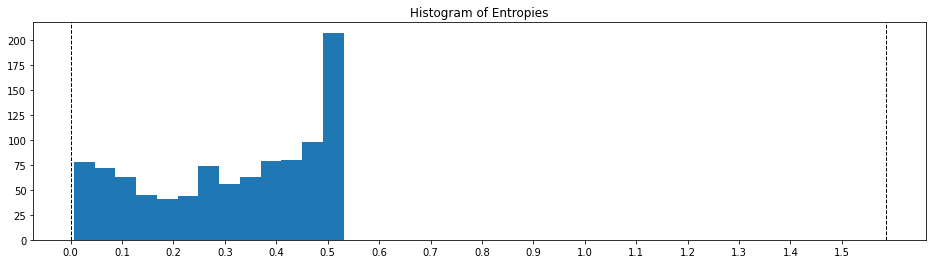

In [32]:
# game 1
f = plt.figure()
f.set_figwidth(16)
plt.hist(entropies, bins = 13)
plt.title("Histogram of Entropies")
min_entropy = 0 # lowest uncertainty (highest certainty)
max_entropy = - 3 * (1/3) * np.log2(1/3) # highest uncertainty, random, uniform distribution
plt.axvline(max_entropy, color='k', linestyle='dashed', linewidth=1)
plt.axvline(min_entropy, color='k', linestyle='dashed', linewidth=1)
plt.xticks(np.arange(0.0, 1.6, 0.1))
fpath = os.path.join(os.getcwd(), "game1_entropy_histogram_a_to_an.png")
plt.savefig(fname=fpath, dpi=300)
plt.show()

### Game 1: Analysis of Failures

In [35]:
parent = os.path.split(os.getcwd())[0]
fpath = os.path.join(parent, "data", "shapeworld", "reference-1000-0.npz")

batch = np.load(fpath)

imgs, labels, utterances = (batch['imgs'], batch['labels'].argmax(-1), batch['langs'])

In [36]:
fail_index_list = [index for index, value in enumerate(lis_pred) if value != 0]
fail_index_list

[9,
 13,
 18,
 35,
 57,
 65,
 68,
 74,
 81,
 87,
 92,
 93,
 94,
 100,
 102,
 104,
 106,
 107,
 110,
 117,
 126,
 130,
 131,
 135,
 136,
 140,
 150,
 152,
 163,
 166,
 167,
 173,
 178,
 185,
 187,
 193,
 194,
 202,
 204,
 208,
 209,
 213,
 214,
 216,
 218,
 220,
 223,
 229,
 230,
 232,
 233,
 235,
 247,
 248,
 249,
 254,
 270,
 275,
 276,
 279,
 282,
 283,
 286,
 289,
 294,
 301,
 307,
 309,
 332,
 335,
 338,
 347,
 350,
 360,
 365,
 366,
 367,
 370,
 372,
 377,
 378,
 381,
 382,
 386,
 398,
 400,
 404,
 406,
 408,
 416,
 427,
 440,
 441,
 442,
 448,
 453,
 456,
 458,
 462,
 481,
 493,
 498,
 503,
 504,
 507,
 511,
 515,
 516,
 519,
 522,
 526,
 532,
 539,
 550,
 555,
 556,
 565,
 568,
 570,
 576,
 581,
 591,
 597,
 603,
 605,
 611,
 613,
 615,
 616,
 620,
 623,
 630,
 632,
 633,
 636,
 643,
 644,
 646,
 647,
 651,
 655,
 667,
 670,
 685,
 686,
 698,
 700,
 702,
 707,
 709,
 710,
 714,
 715,
 717,
 718,
 719,
 726,
 729,
 731,
 744,
 746,
 749,
 750,
 751,
 752,
 769,
 781,
 784,
 787,


/tmp/ipykernel_18056/254679980.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 5))


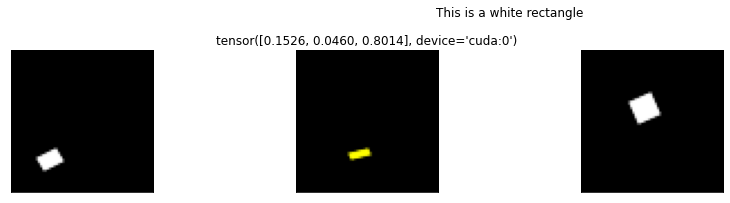

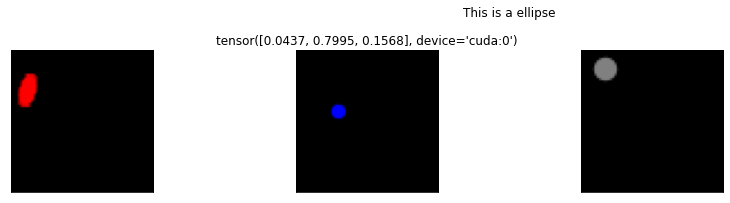

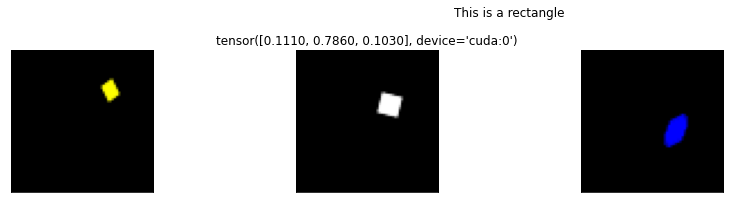

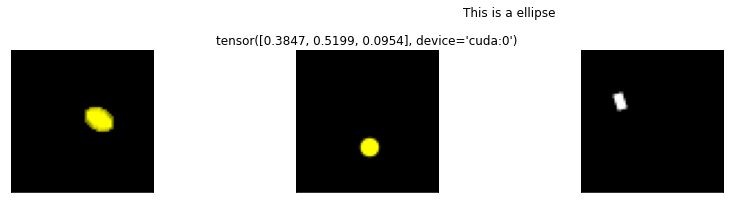

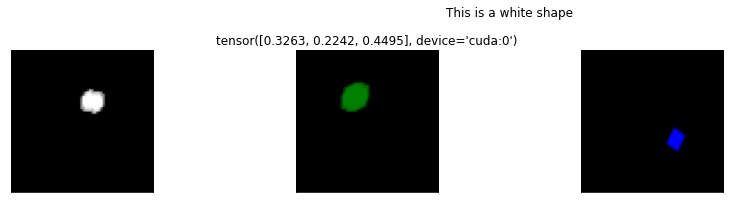

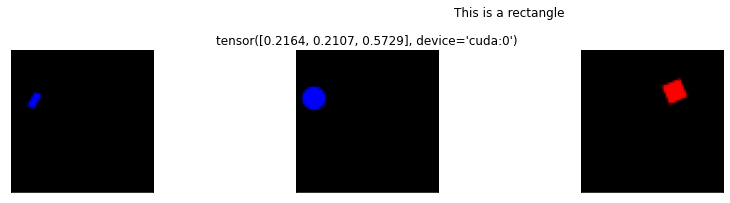

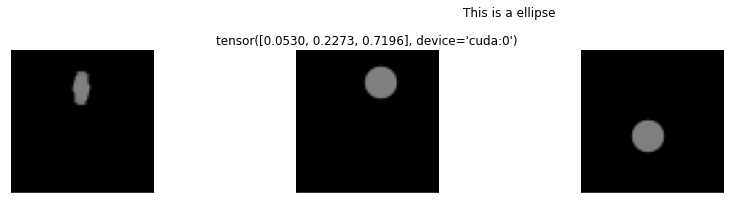

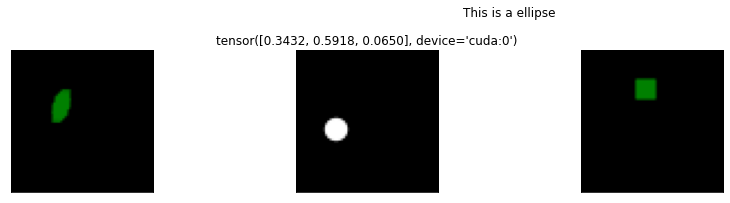

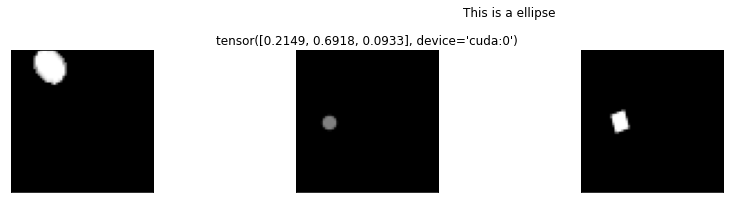

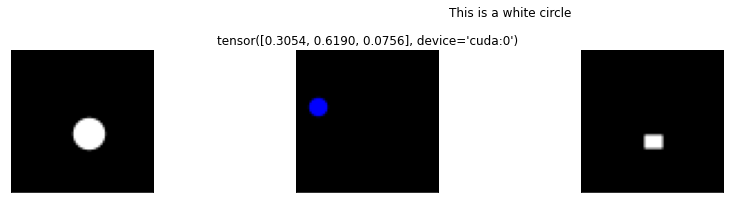

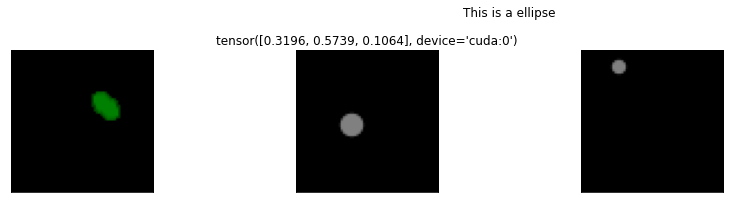

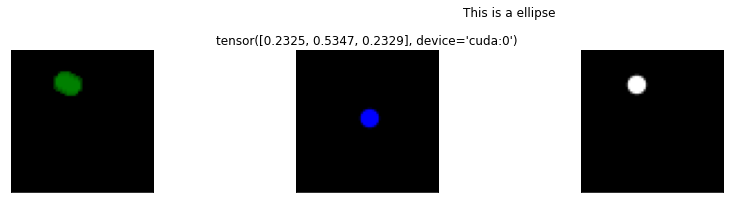

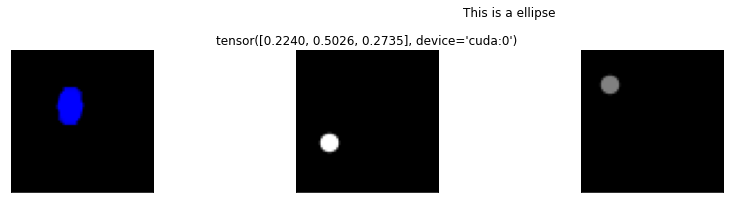

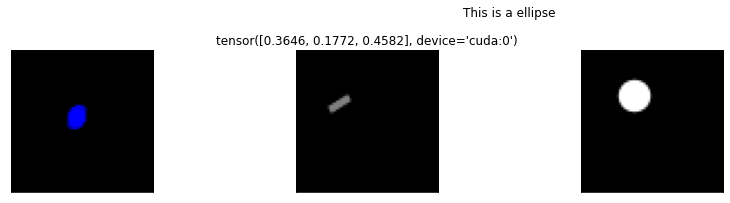

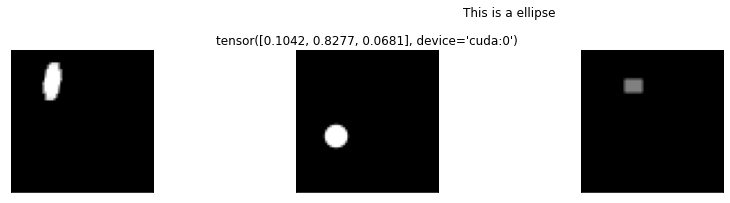

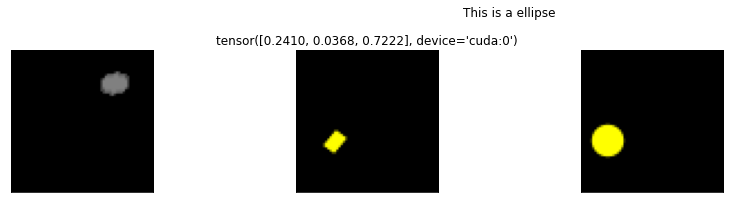

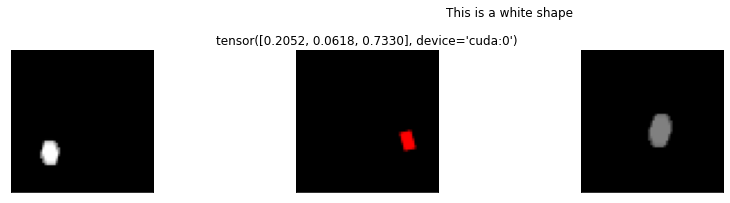

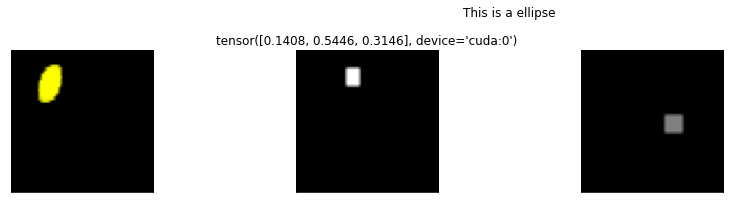

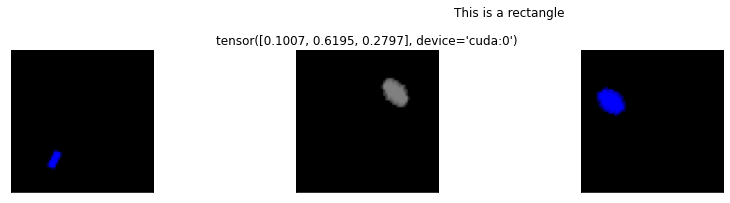

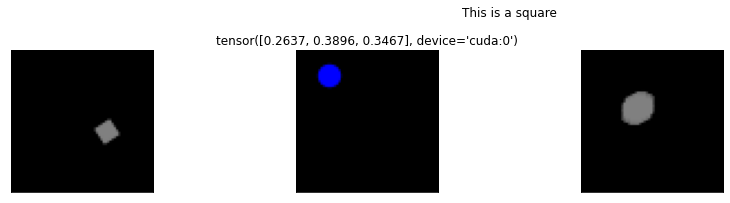

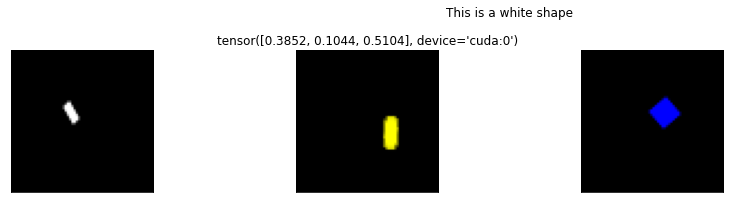

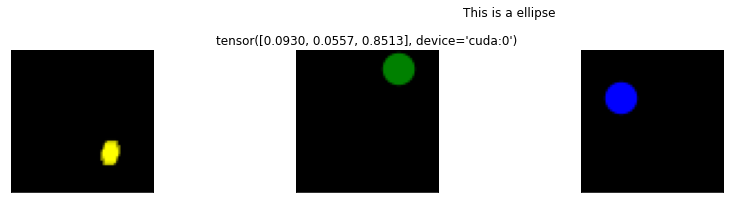

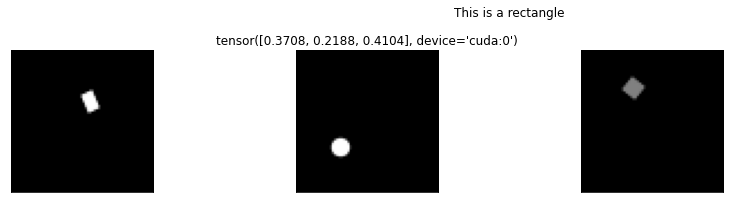

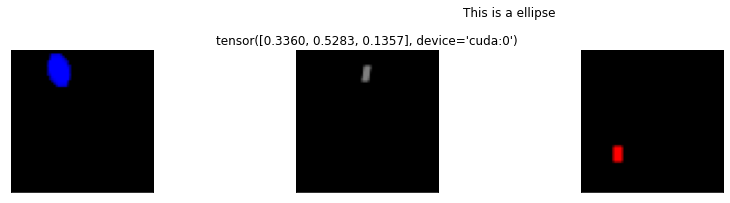

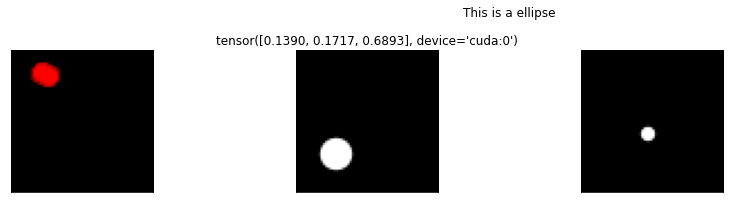

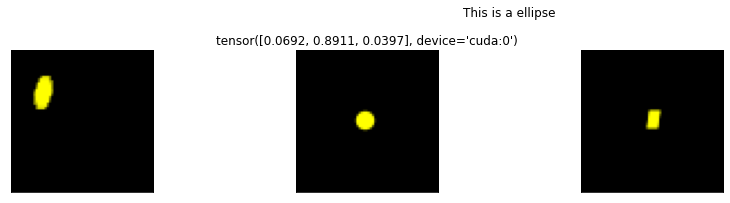

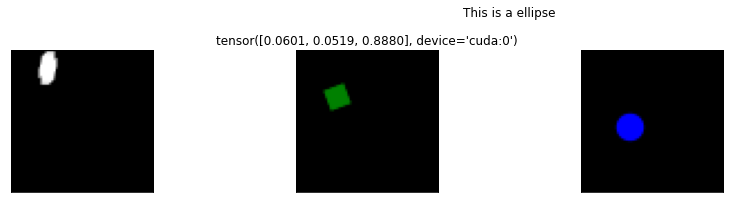

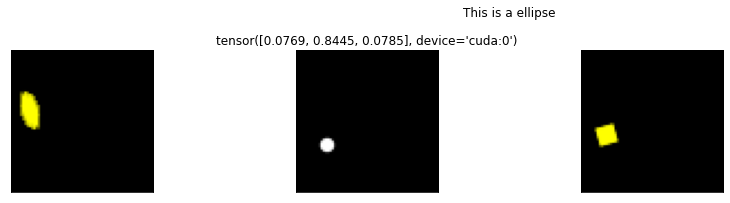

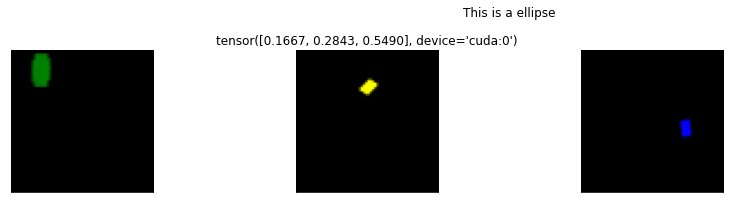

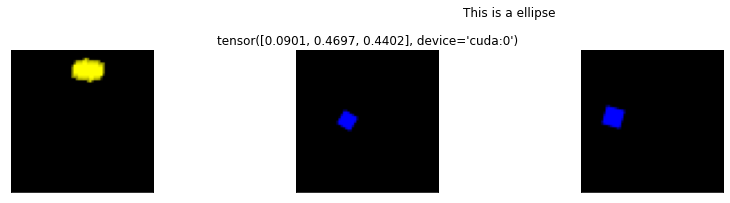

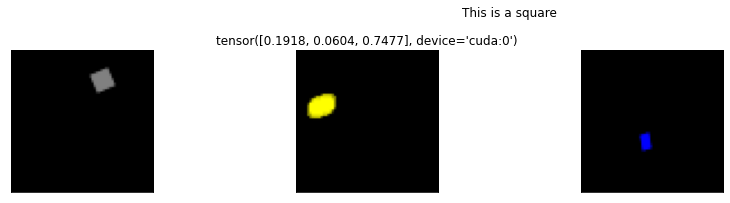

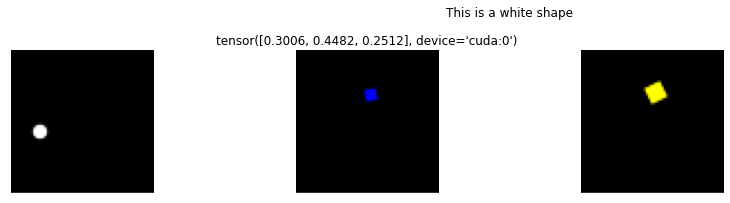

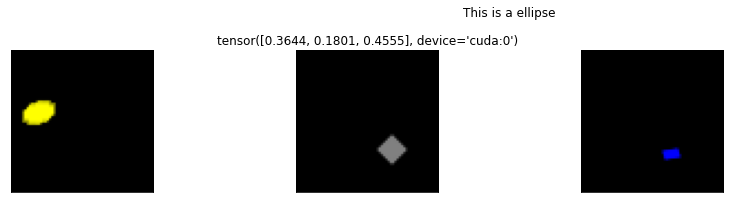

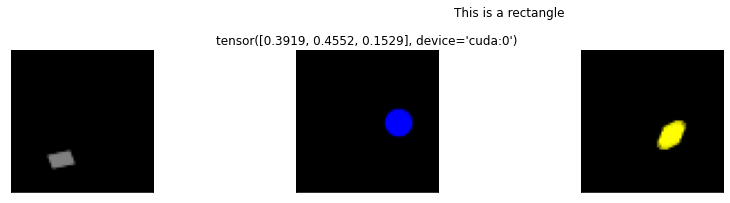

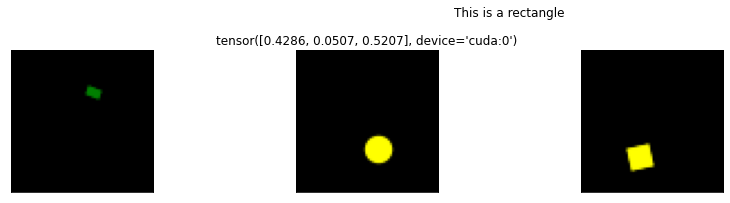

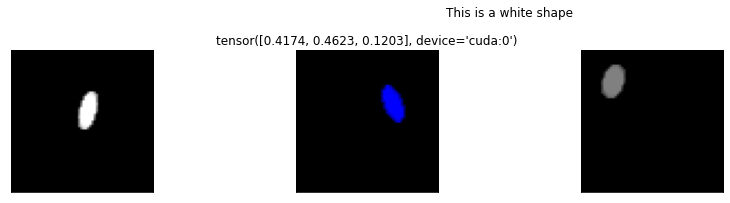

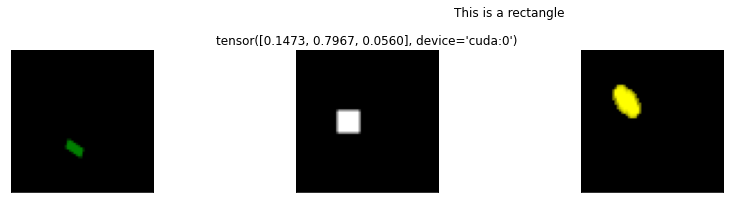

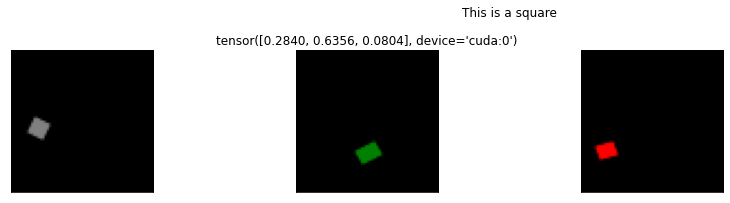

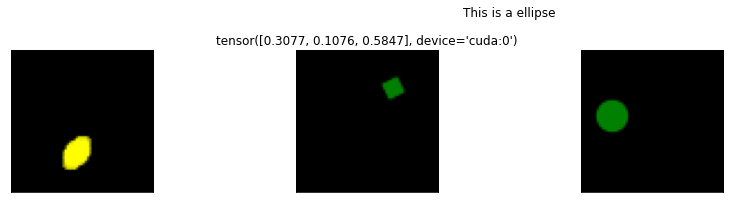

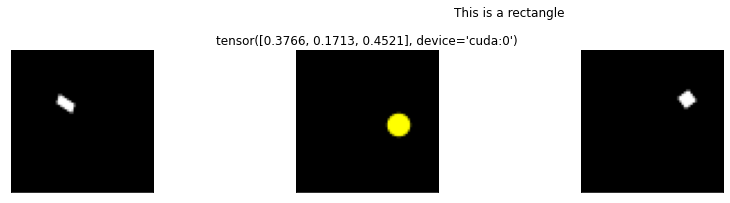

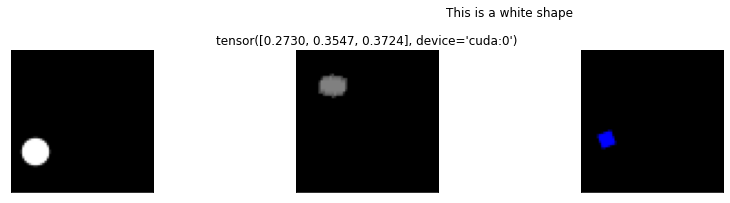

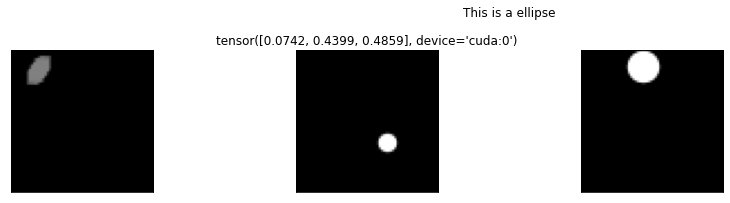

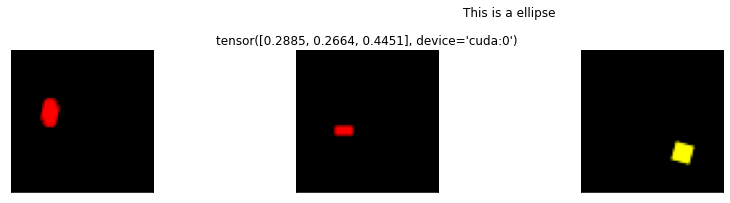

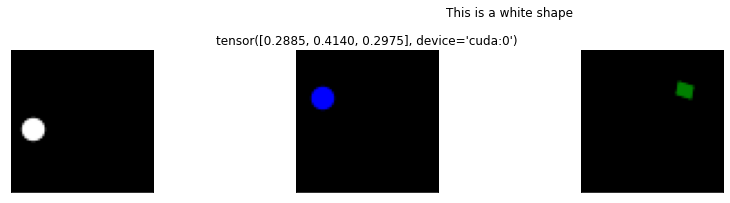

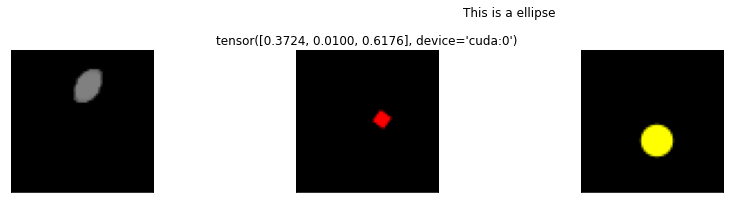

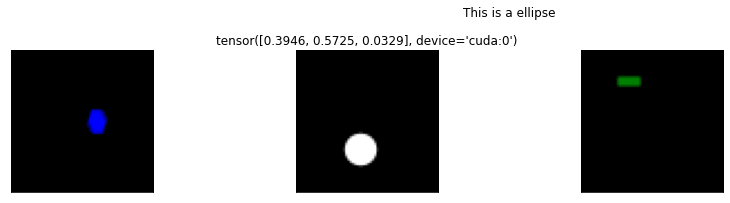

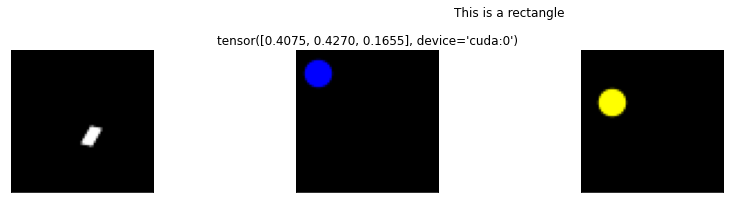

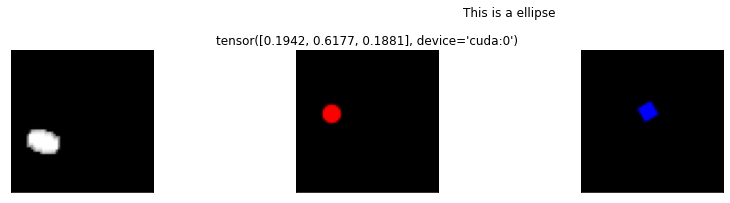

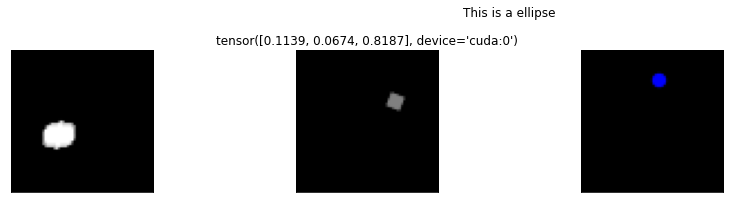

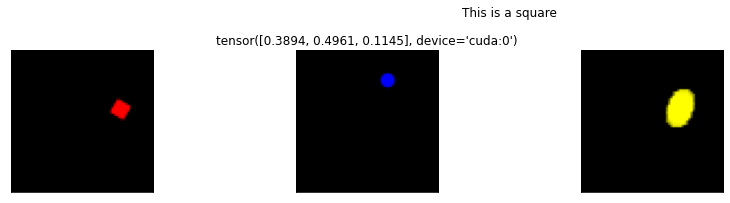

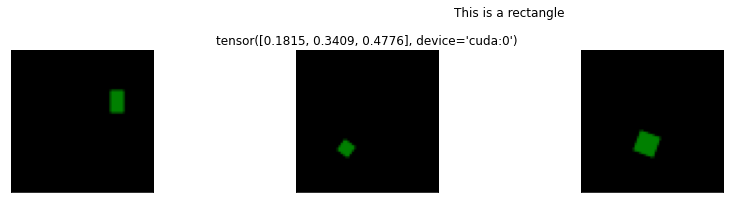

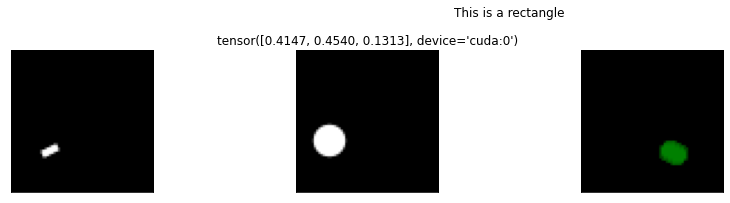

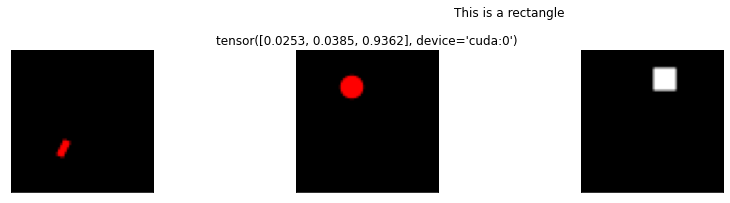

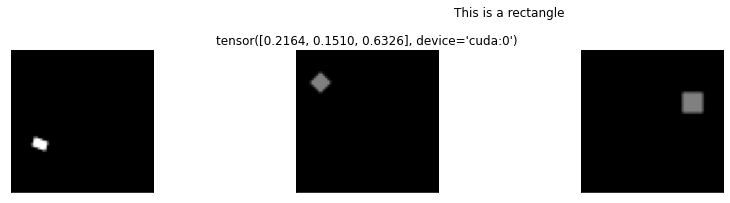

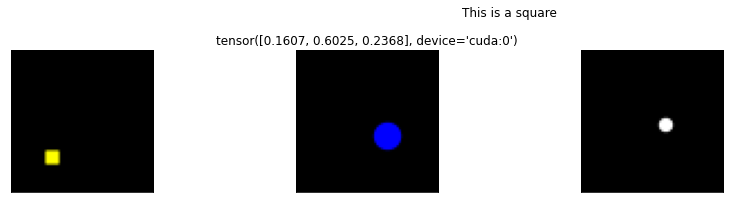

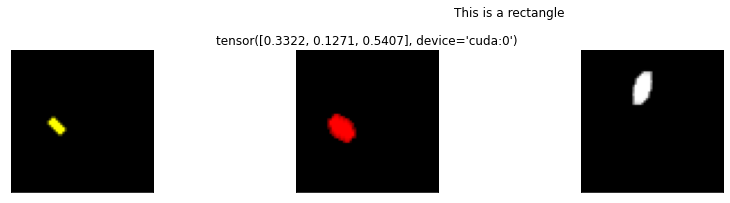

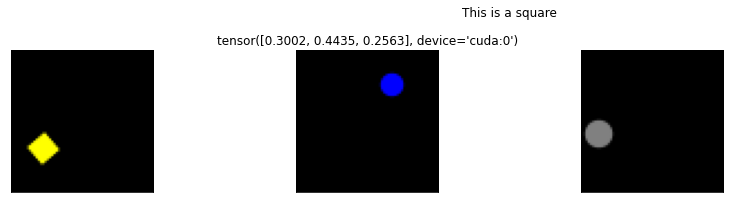

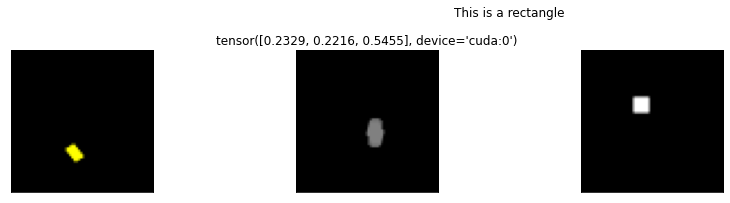

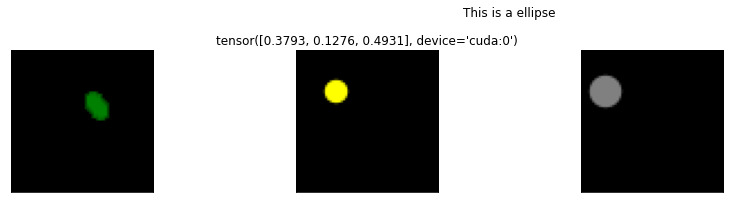

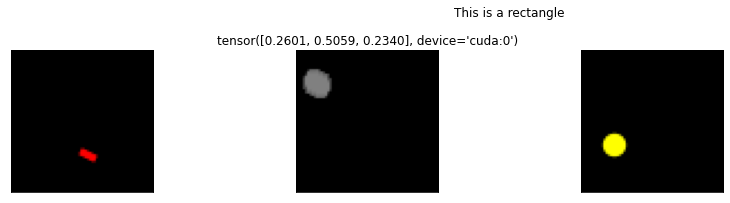

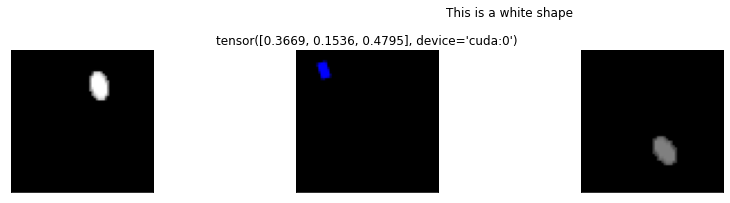

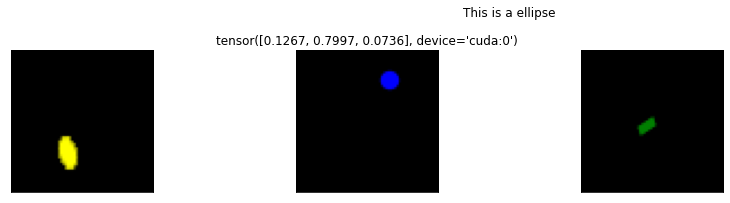

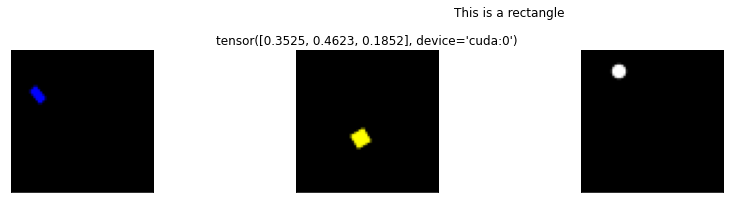

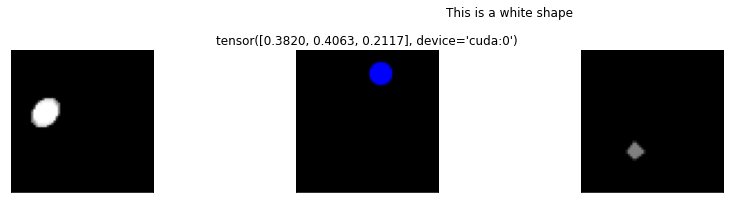

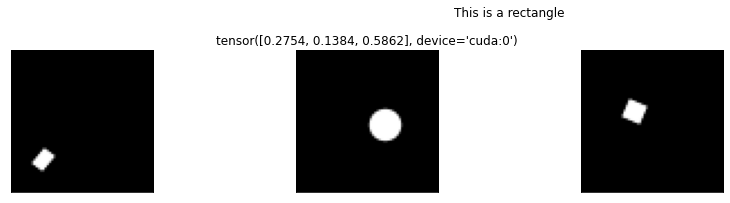

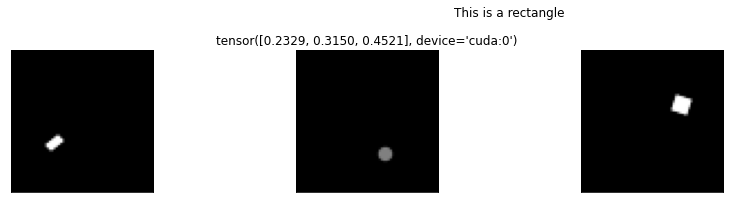

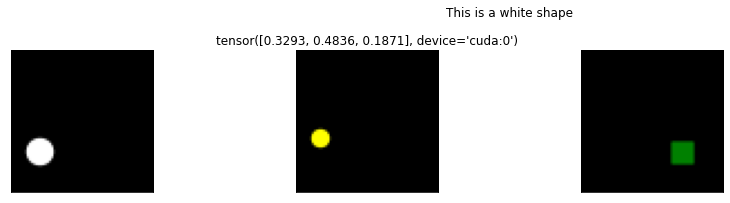

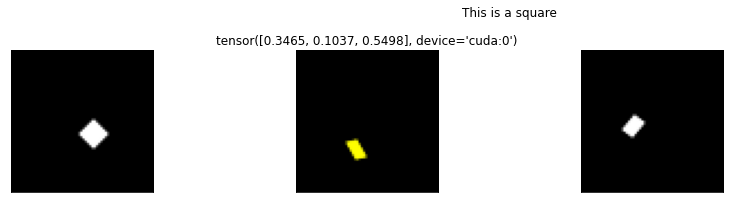

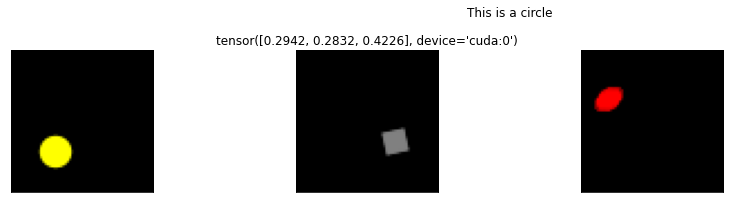

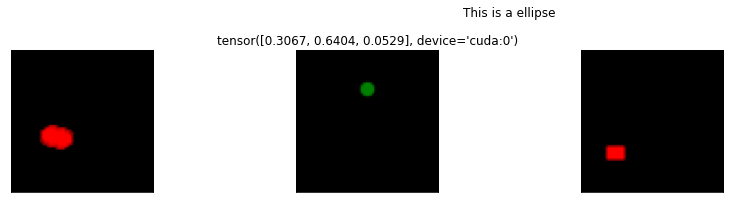

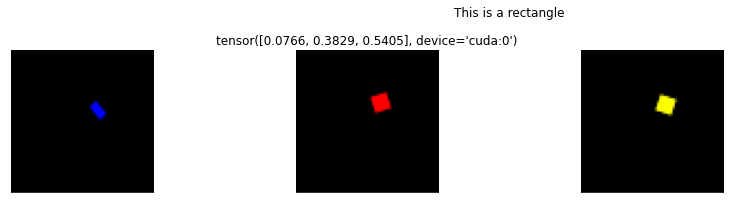

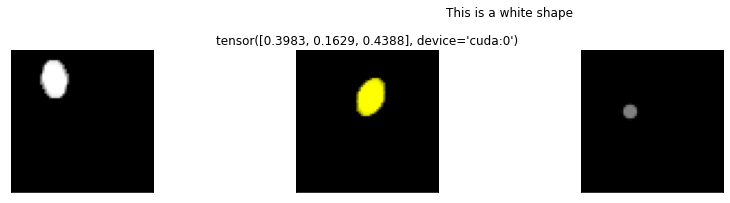

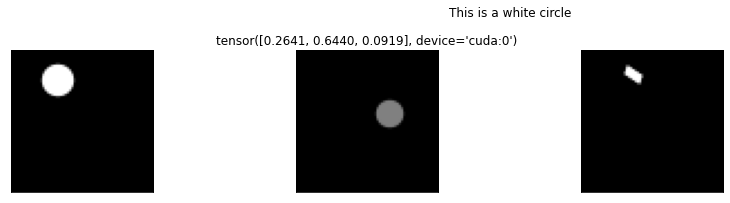

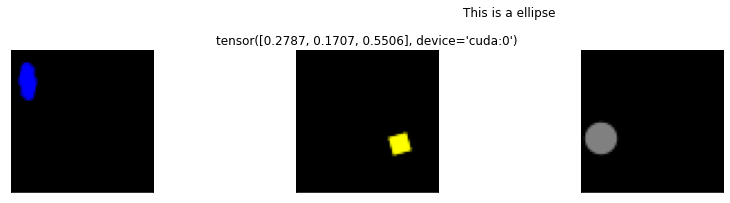

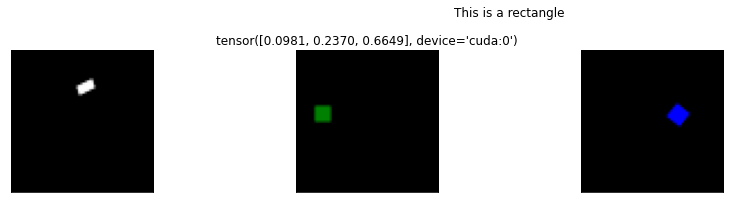

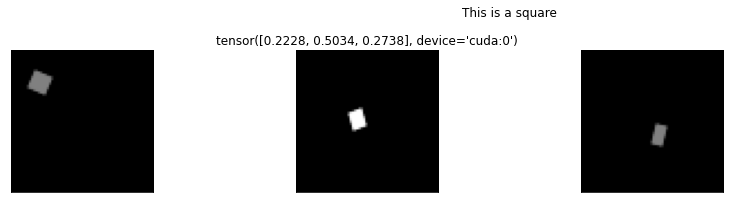

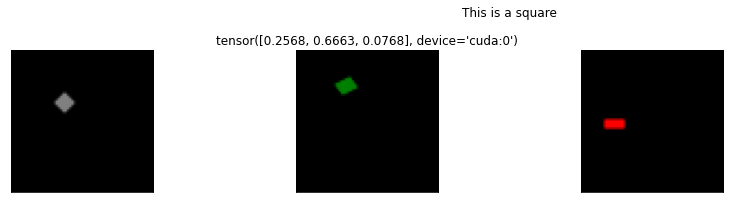

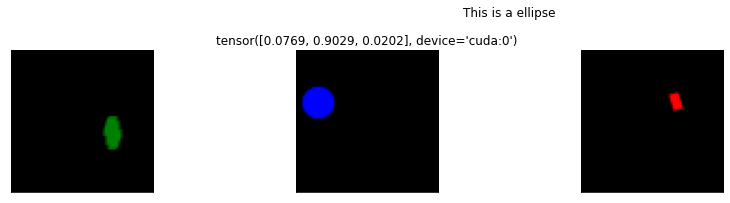

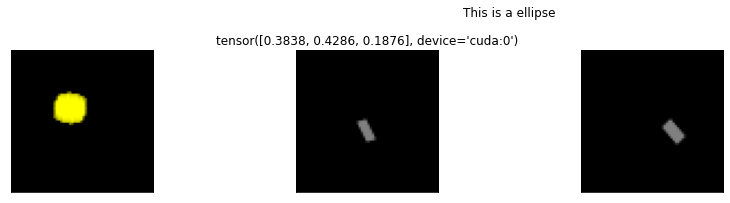

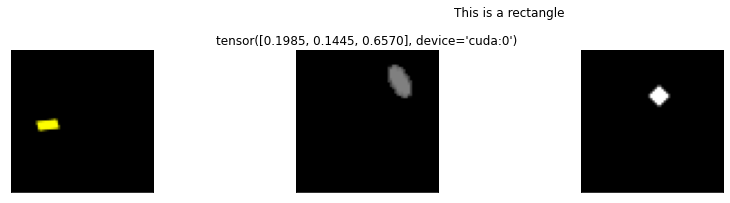

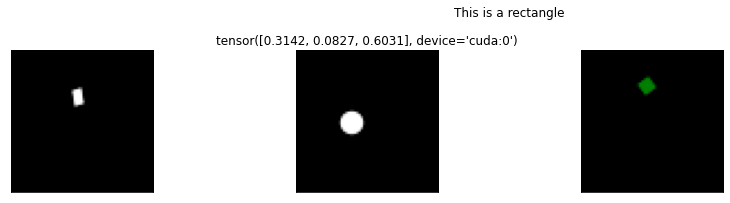

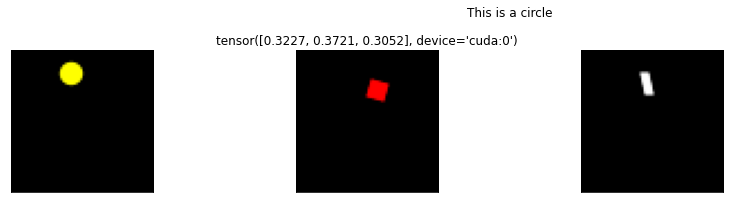

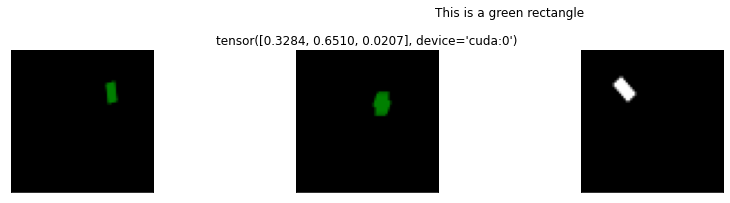

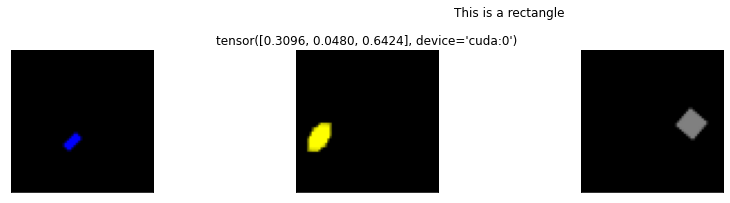

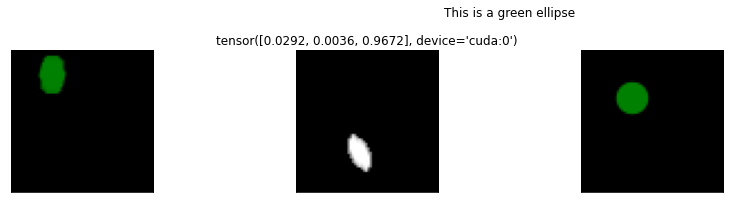

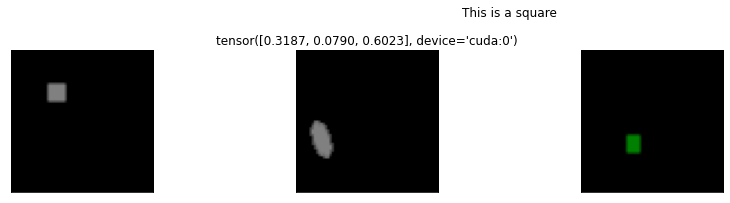

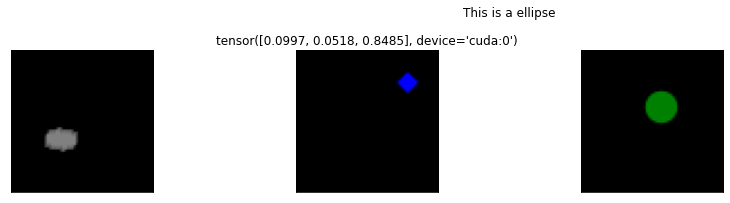

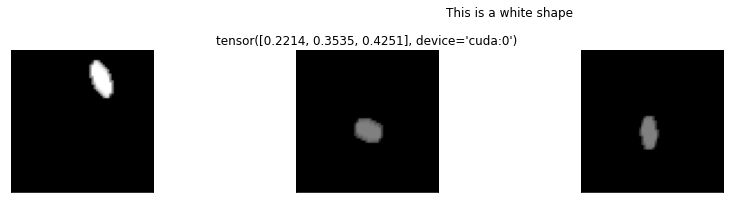

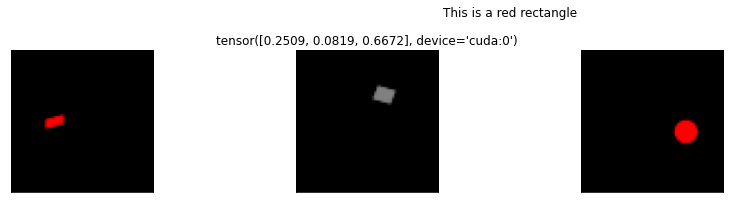

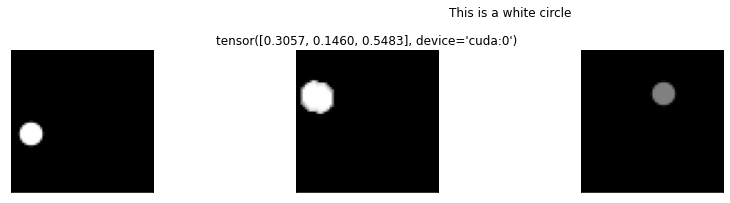

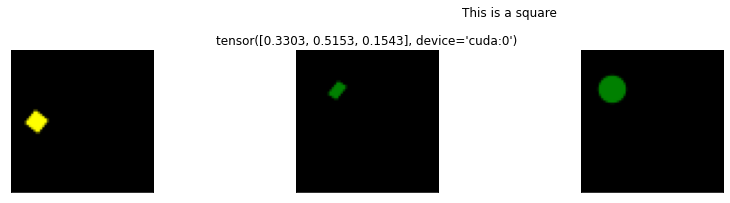

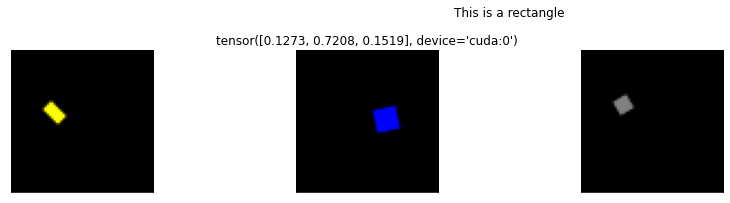

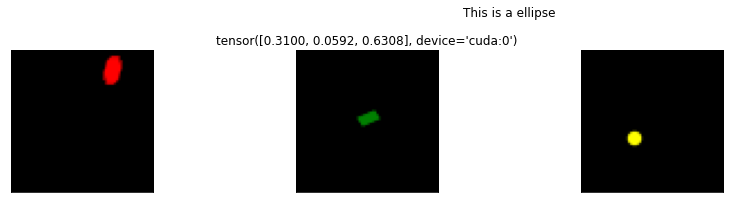

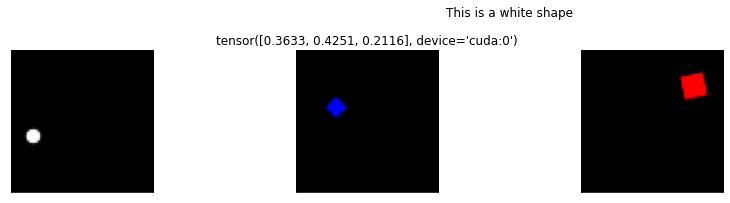

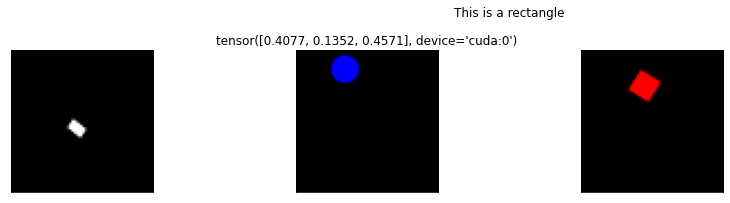

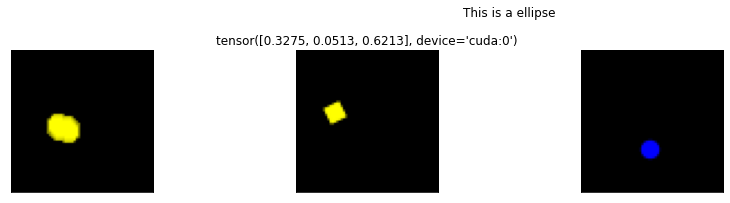

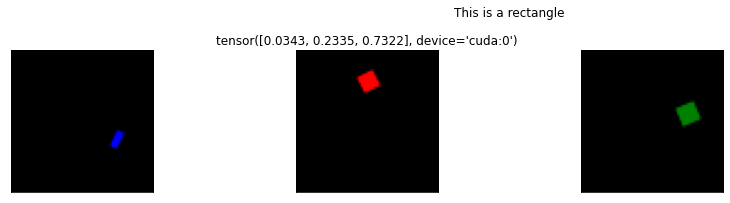

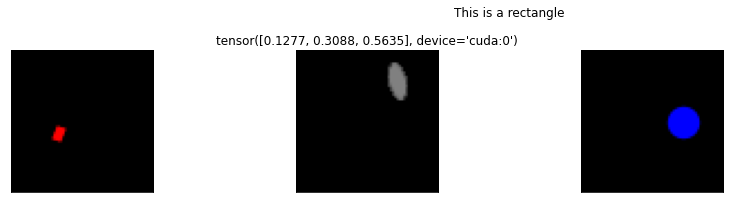

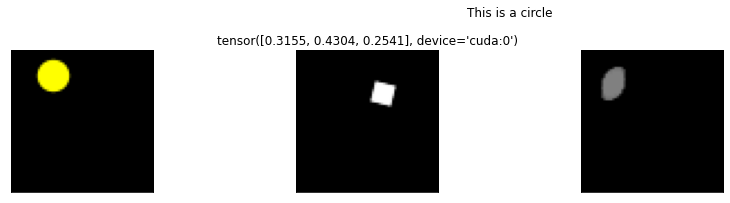

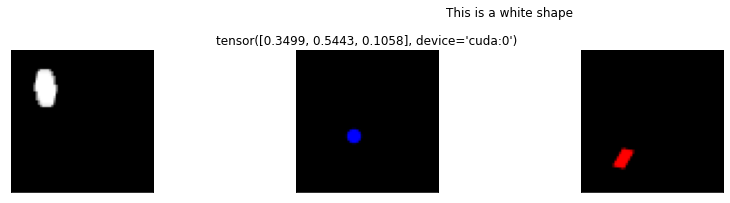

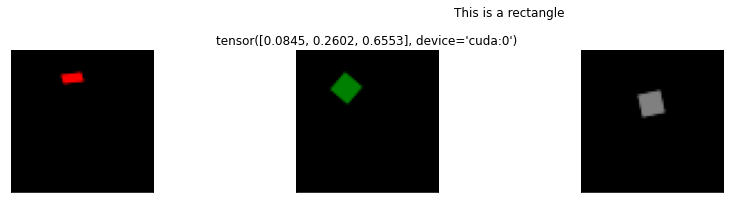

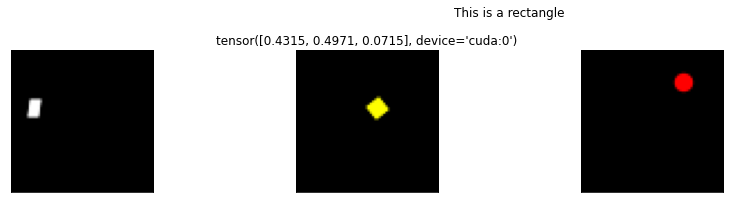

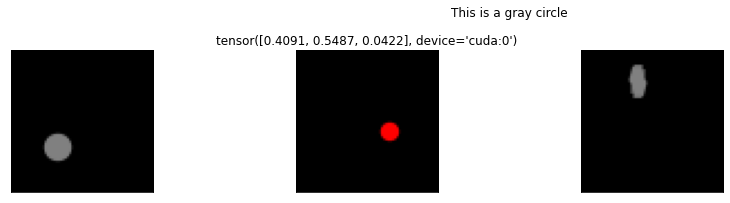

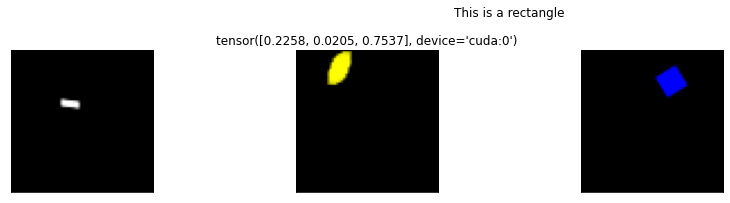

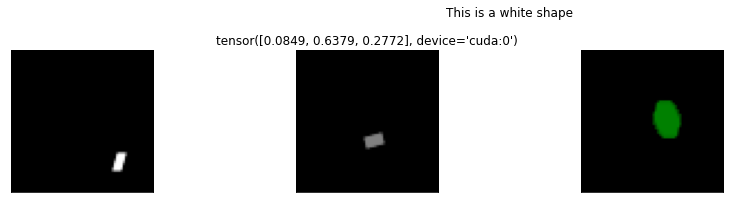

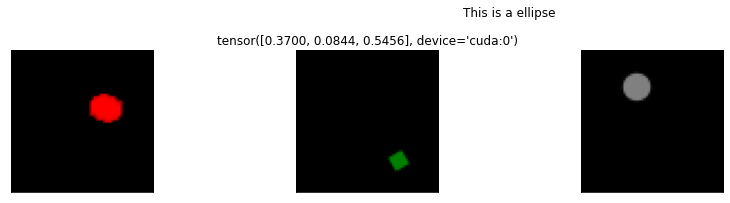

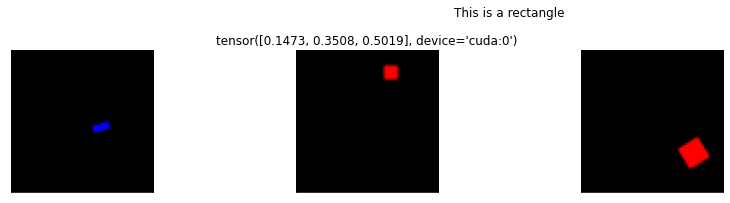

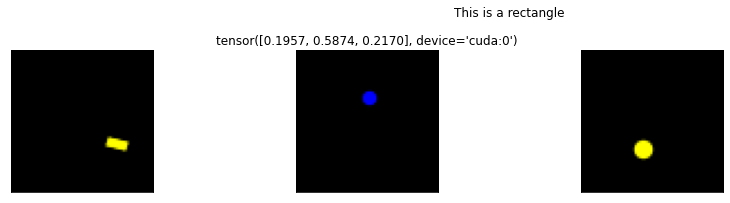

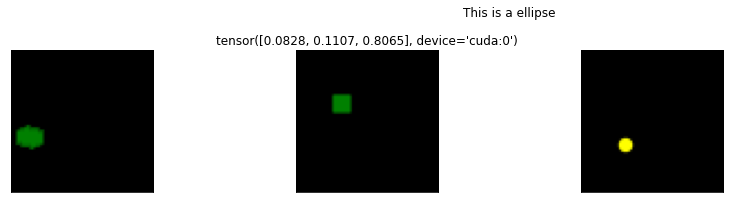

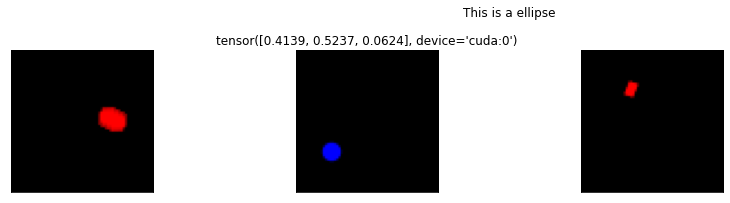

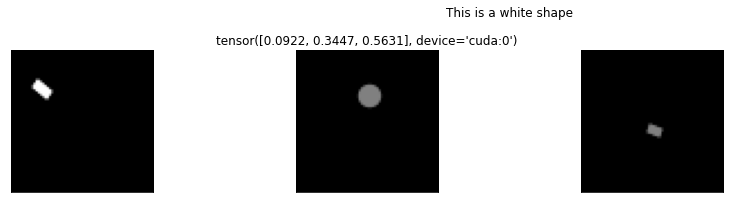

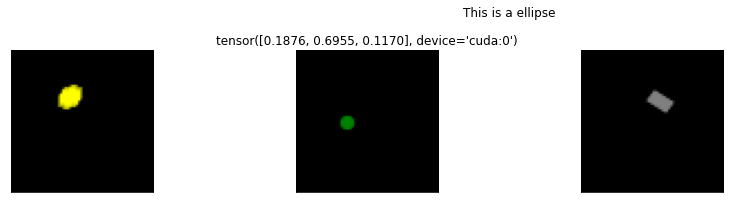

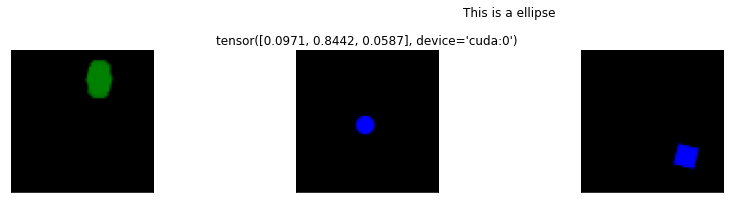

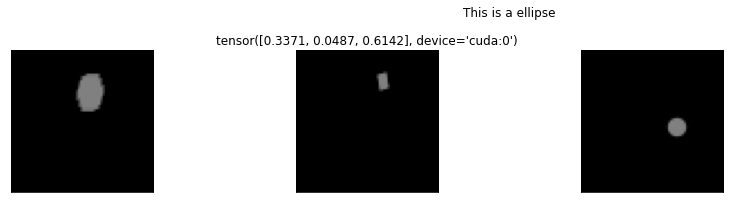

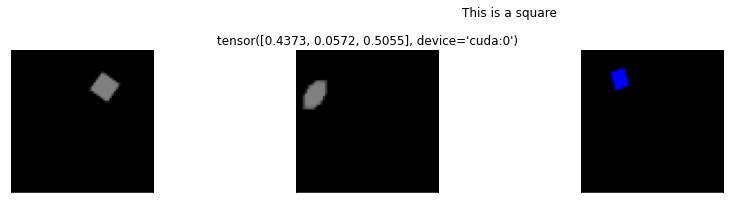

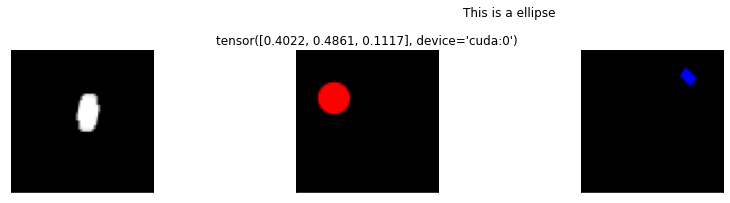

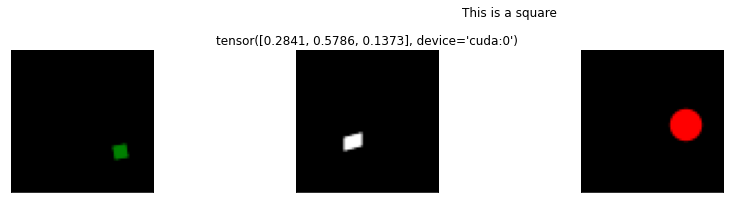

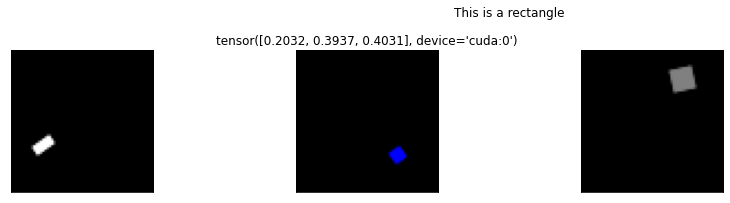

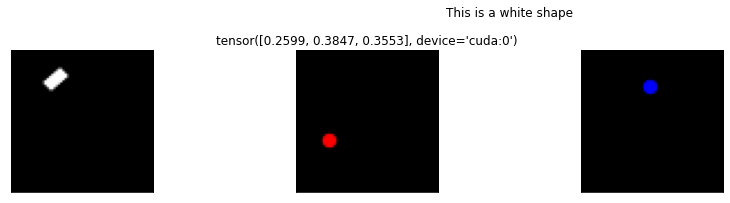

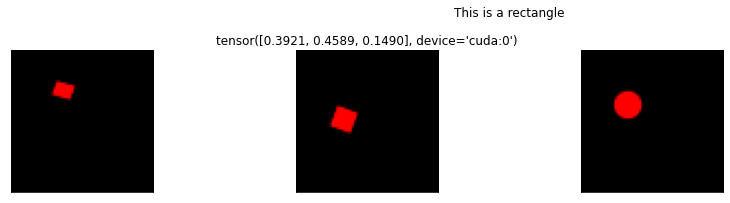

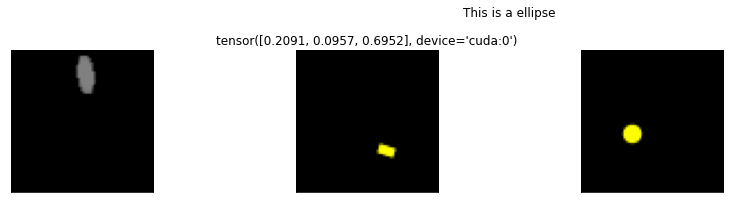

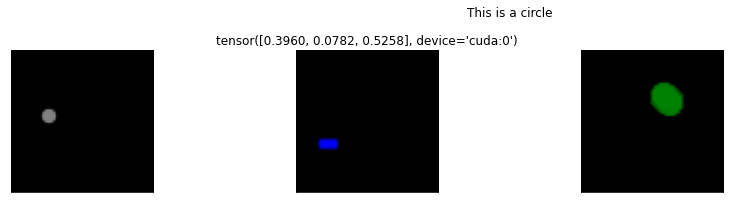

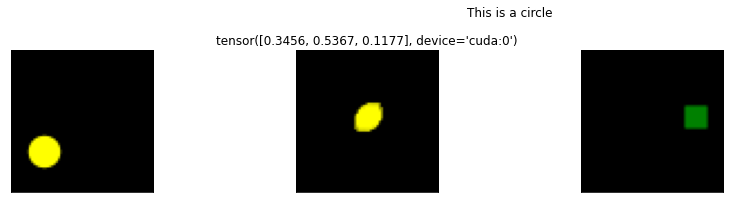

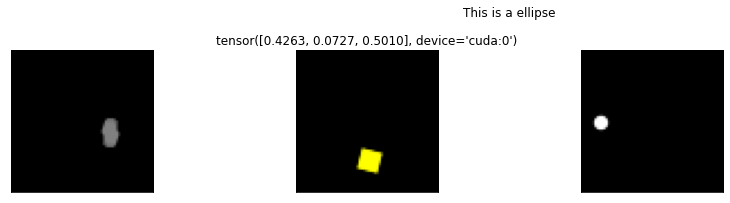

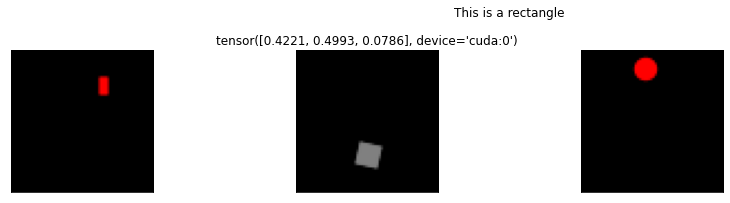

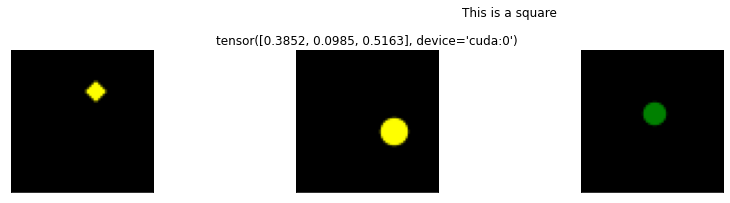

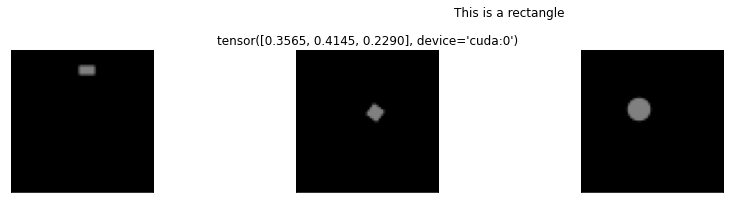

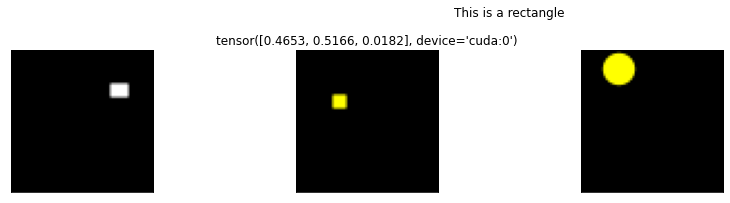

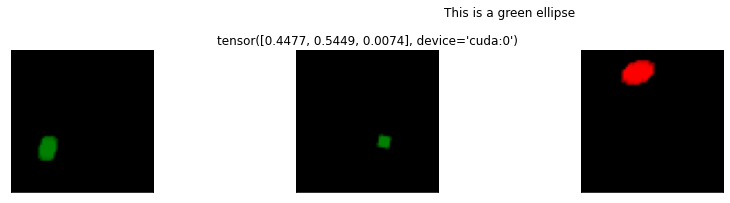

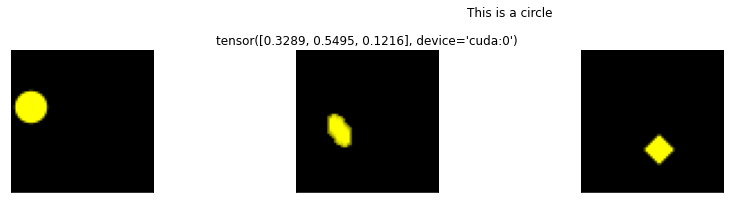

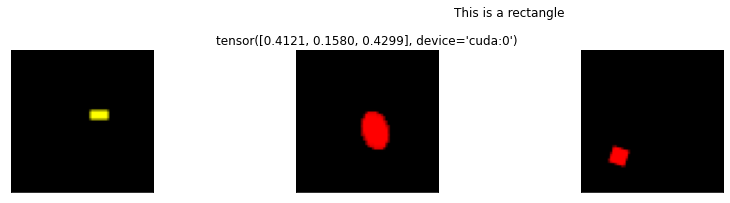

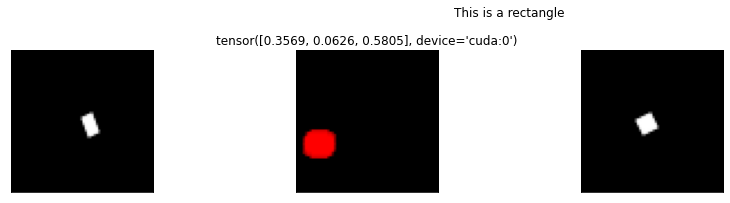

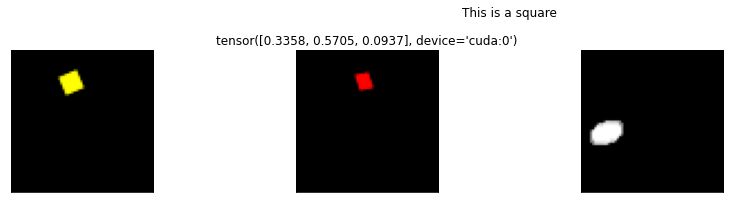

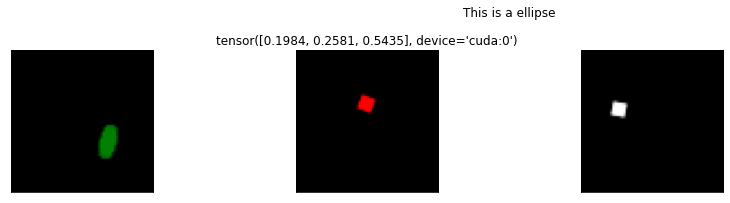

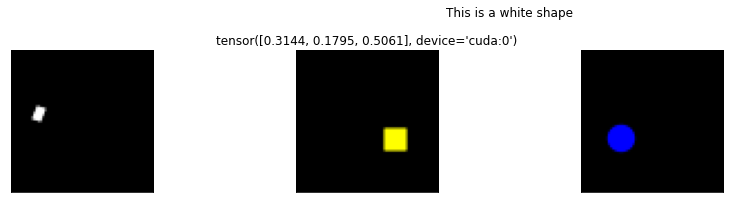

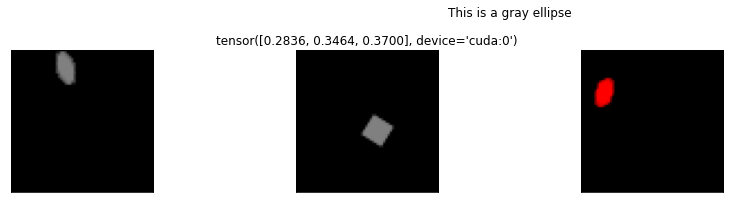

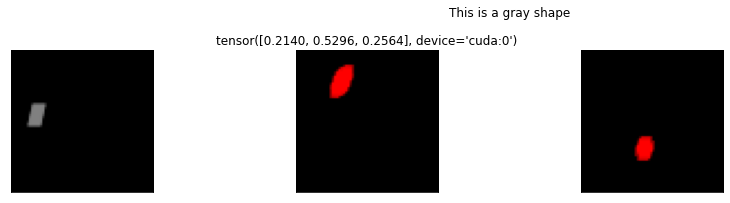

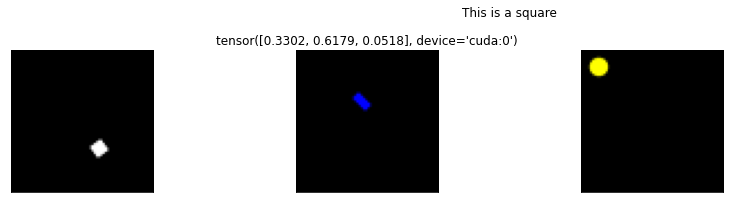

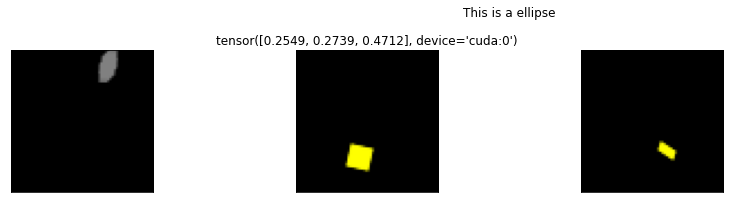

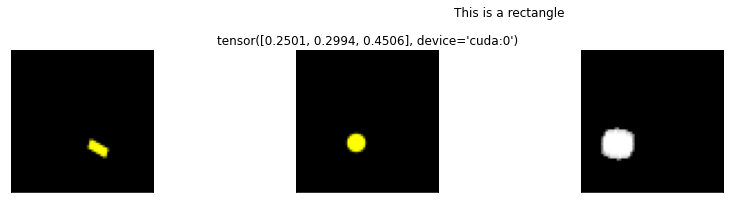

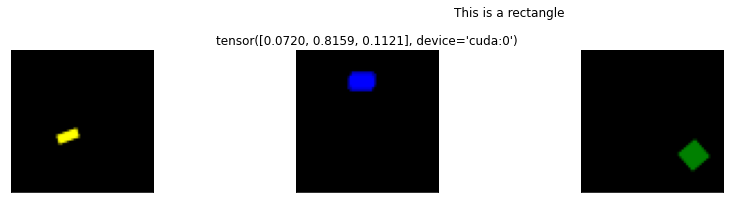

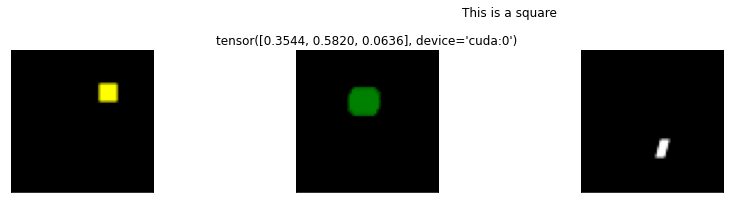

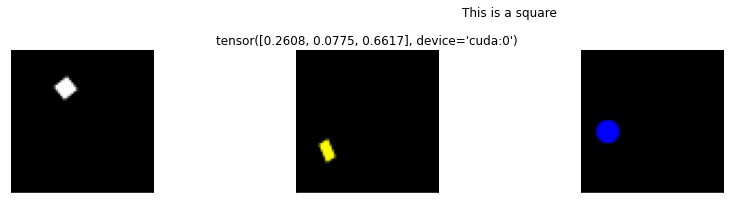

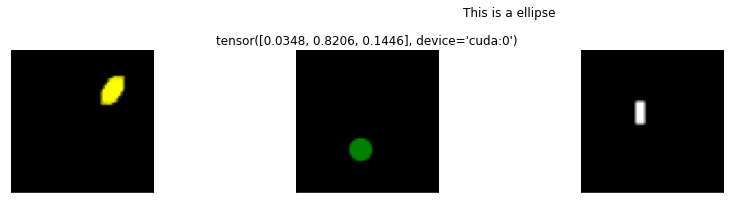

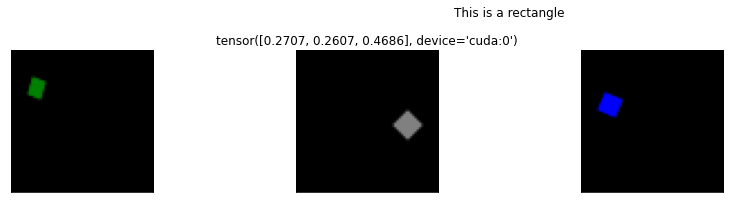

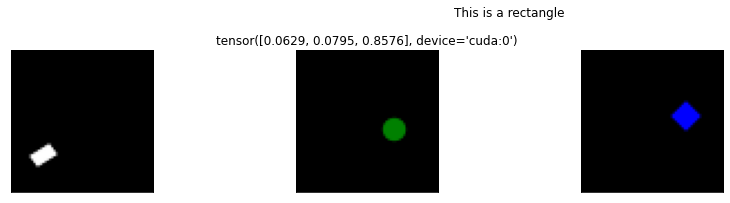

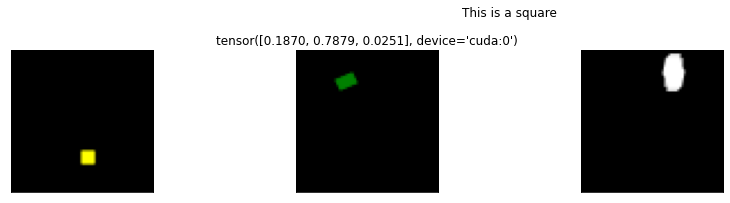

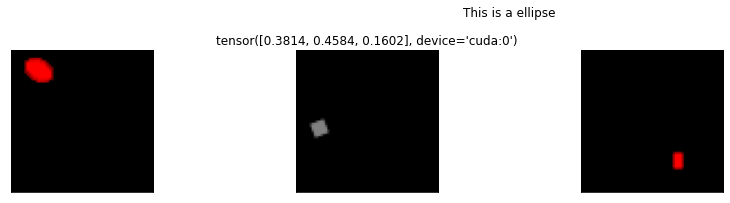

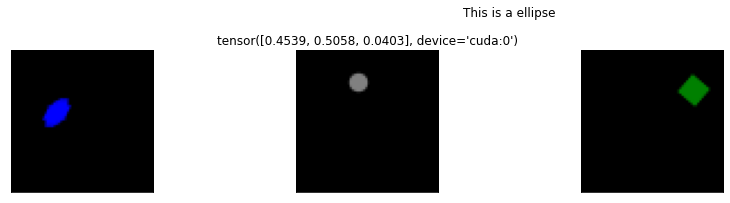

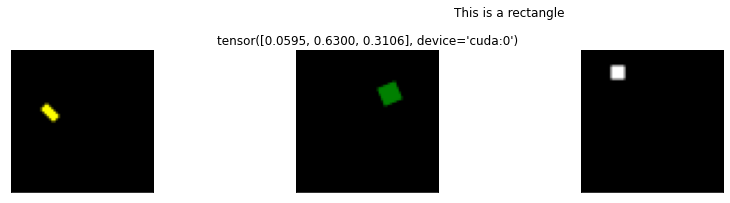

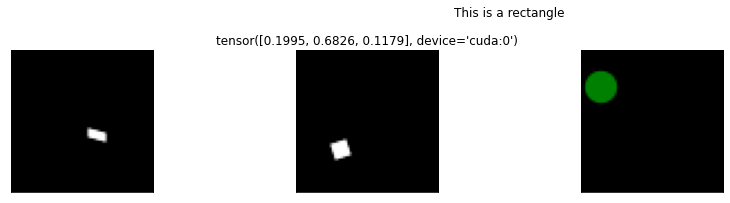

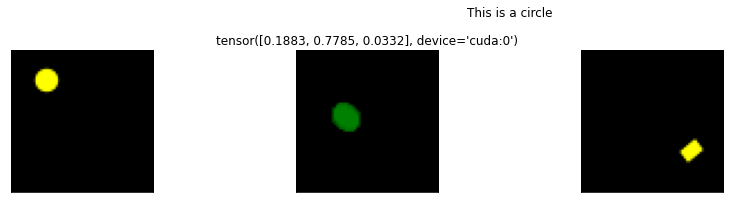

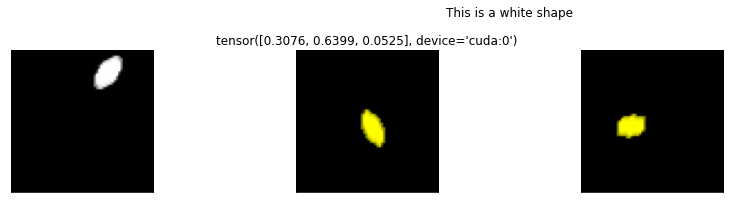

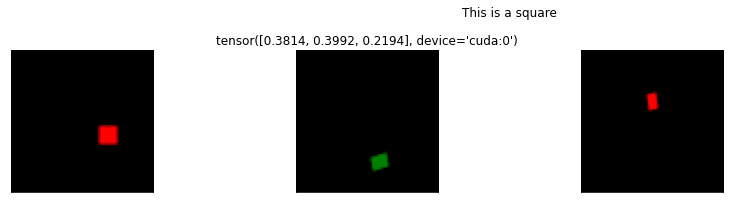

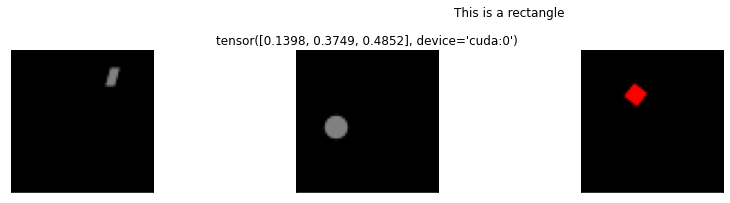

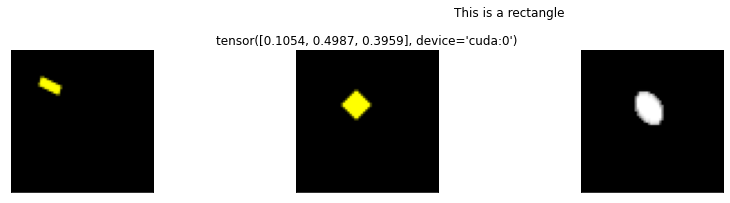

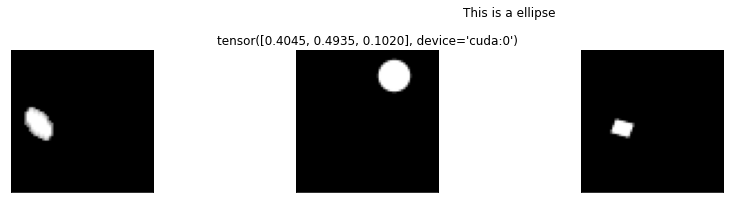

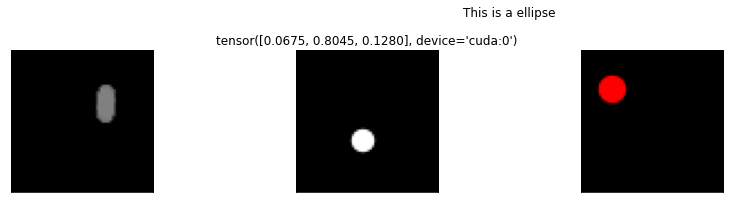

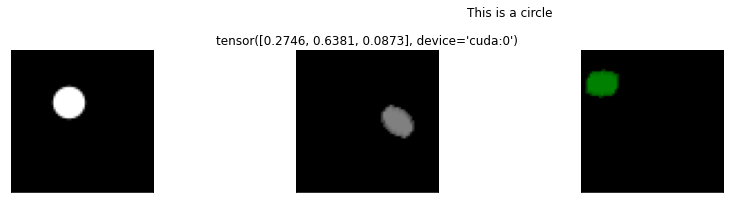

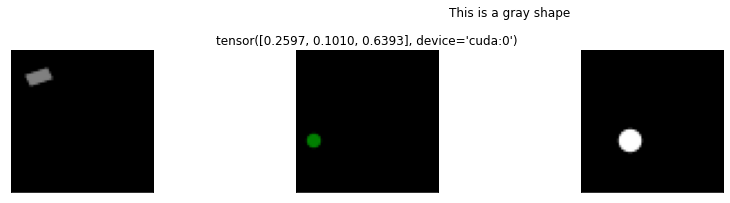

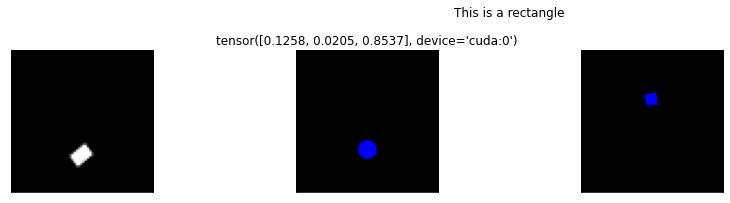

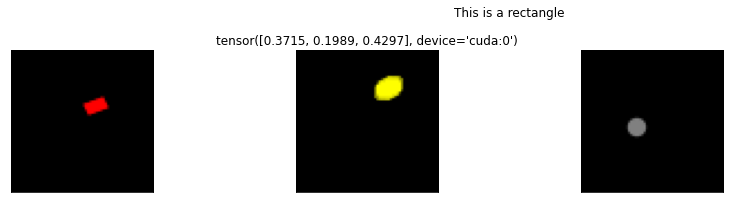

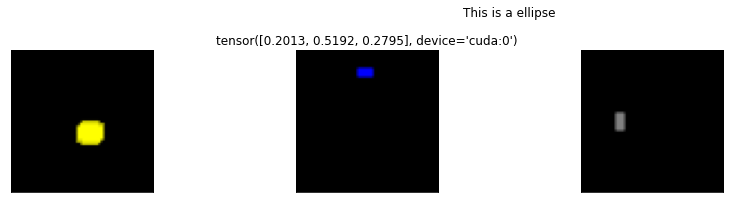

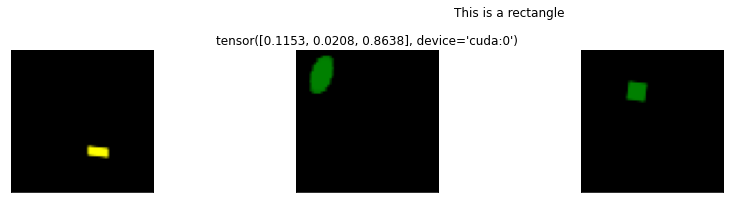

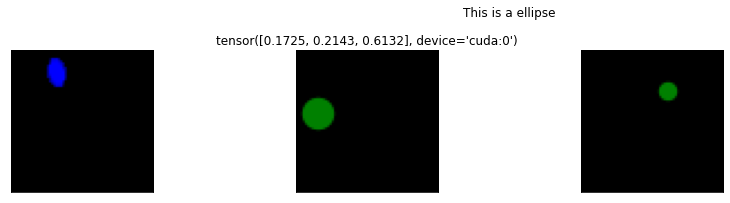

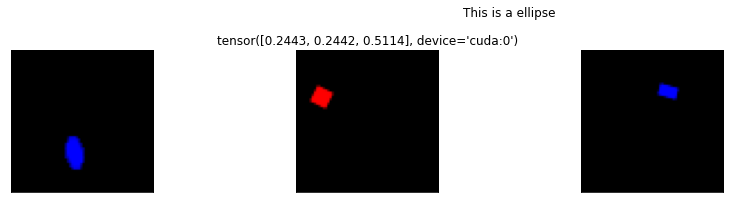

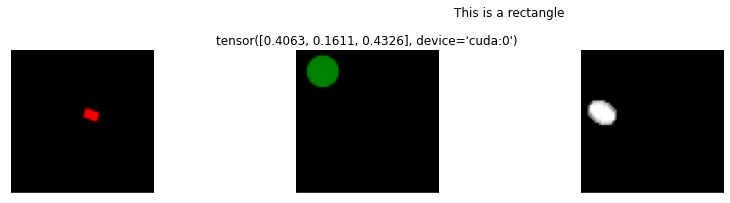

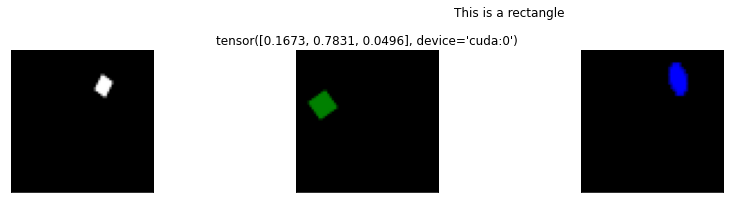

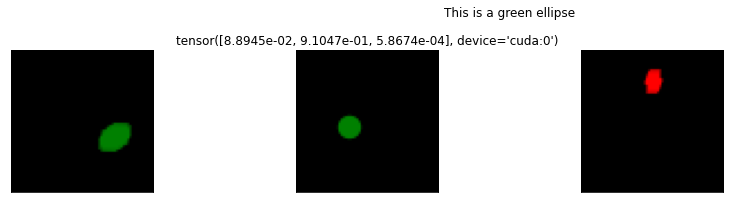

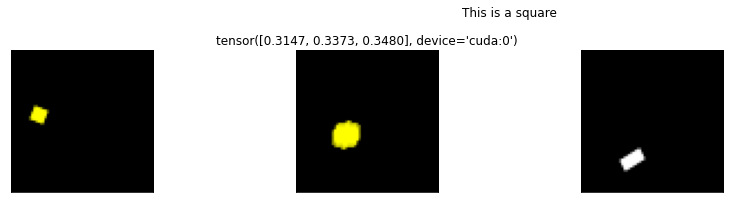

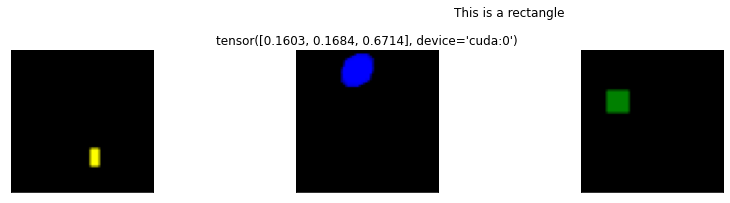

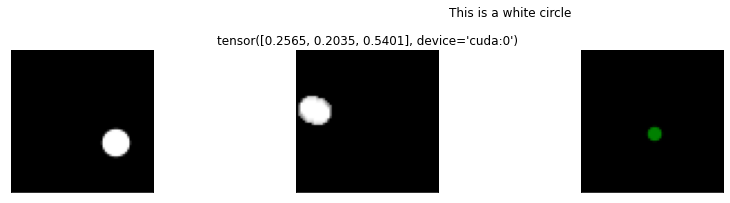

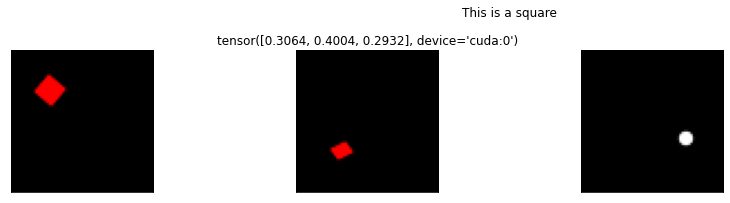

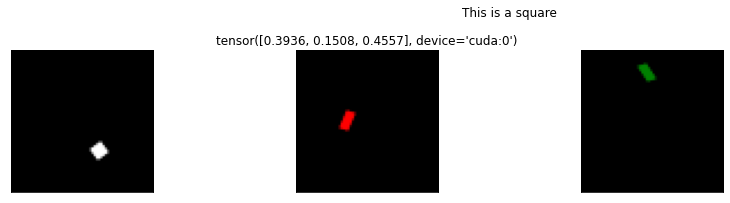

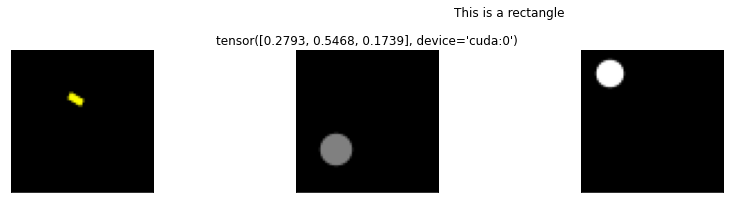

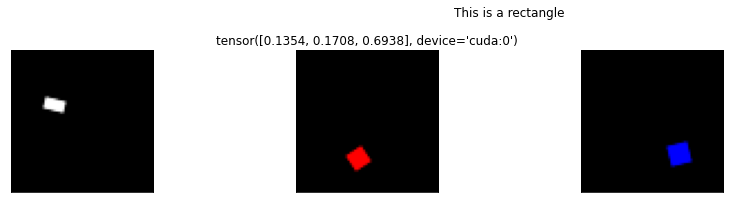

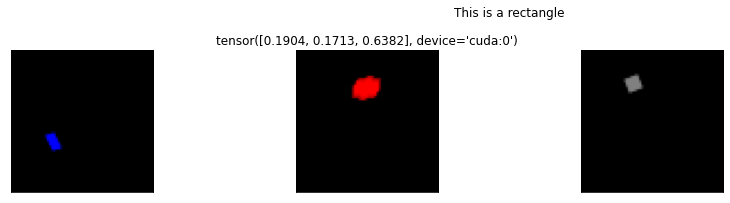

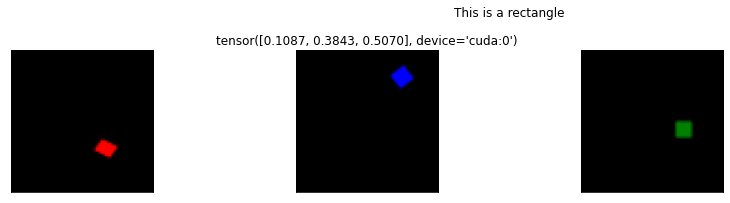

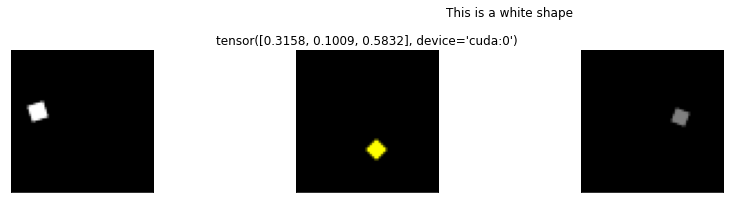

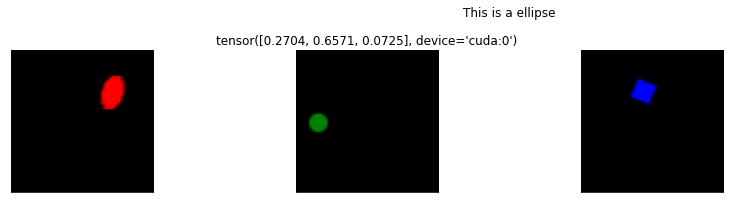

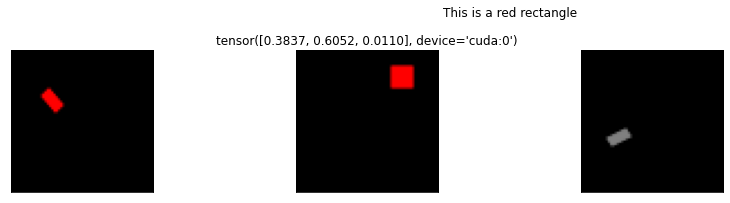

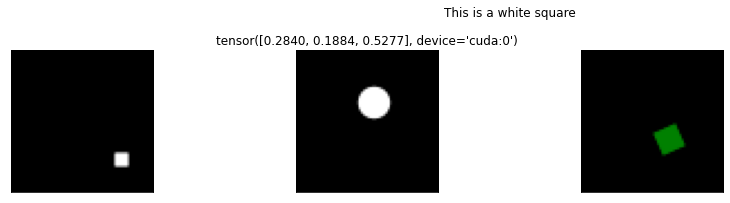

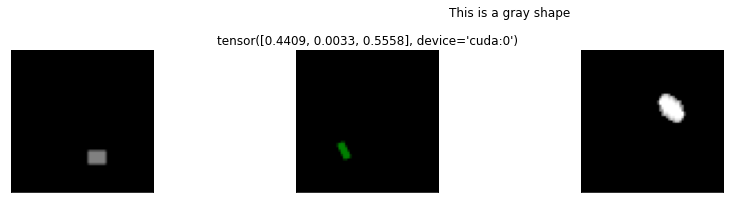

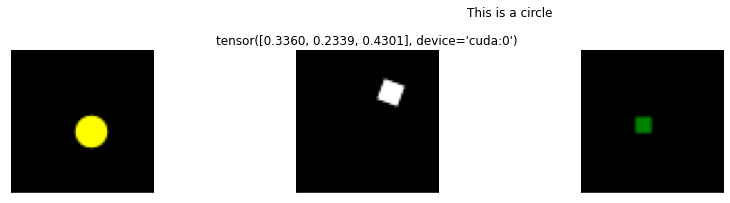

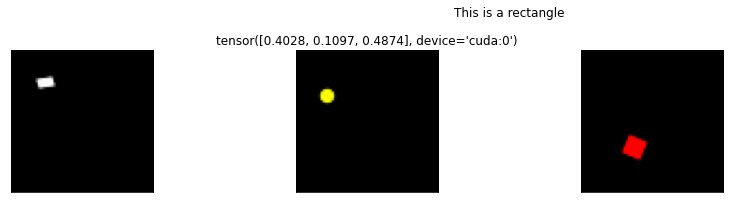

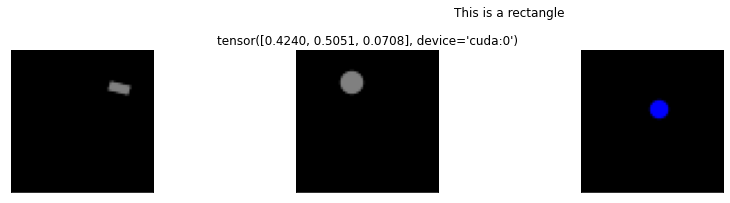

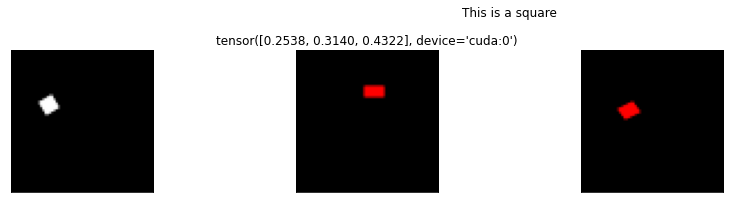

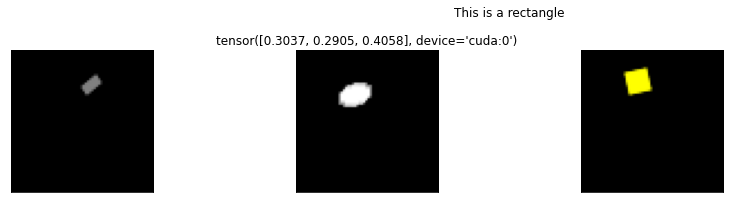

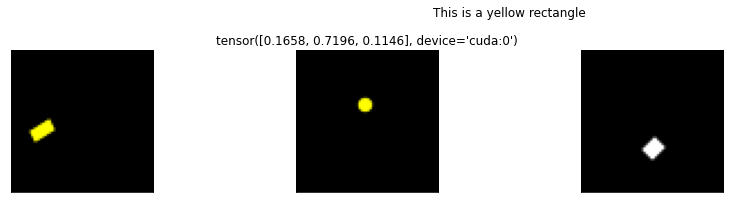

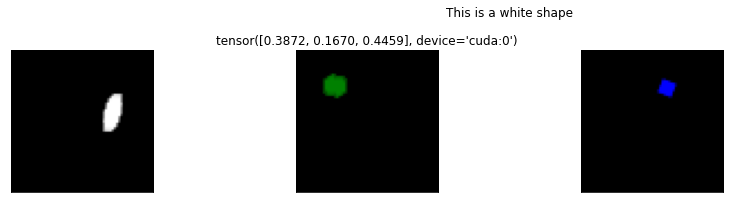

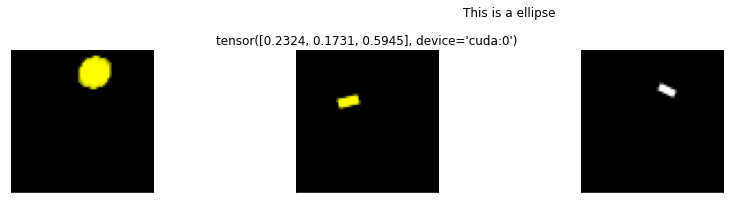

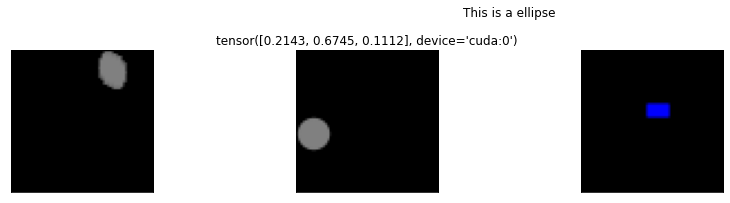

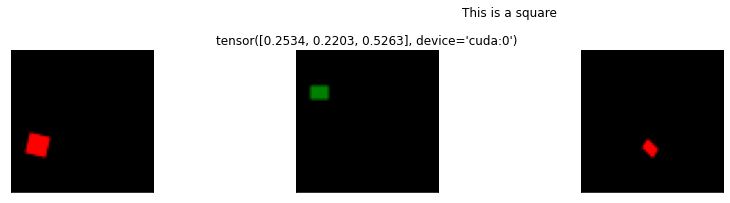

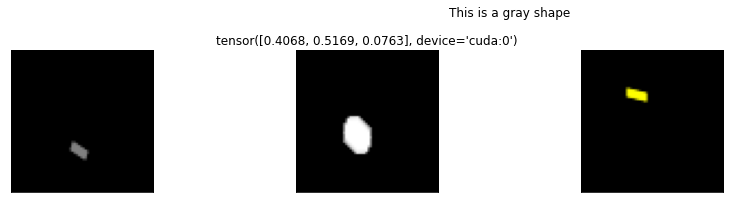

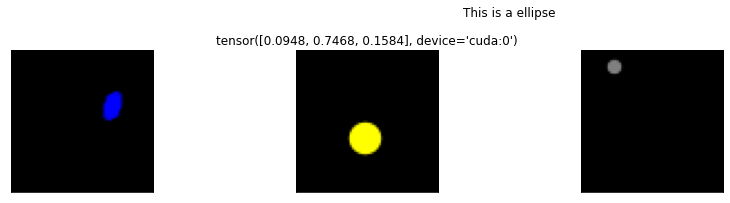

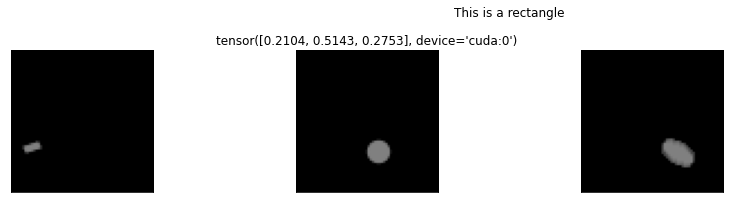

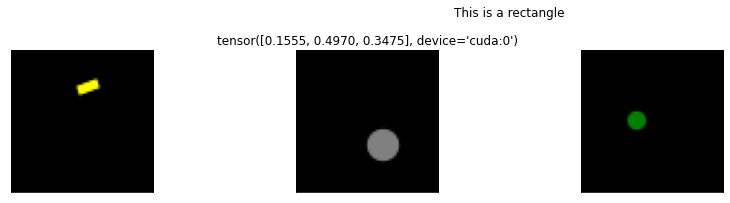

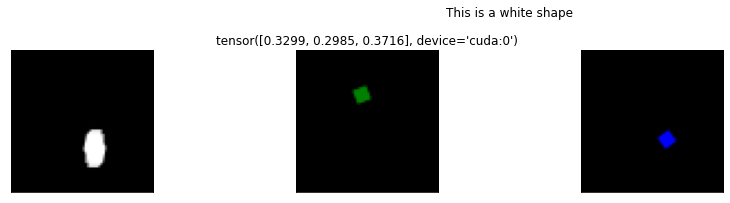

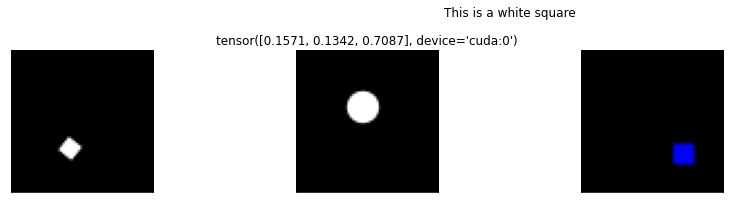

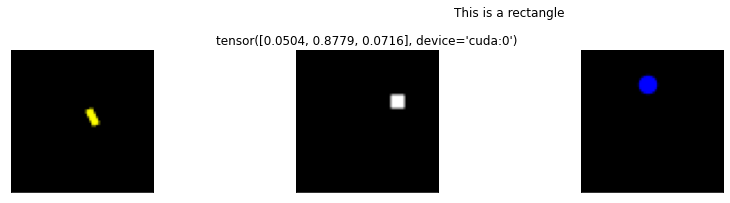

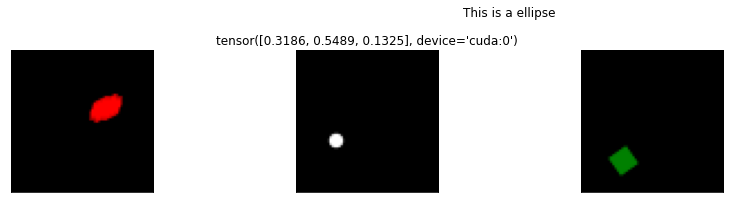

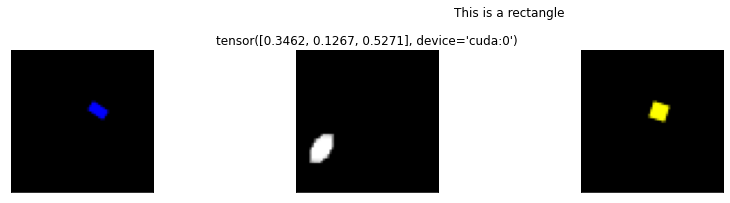

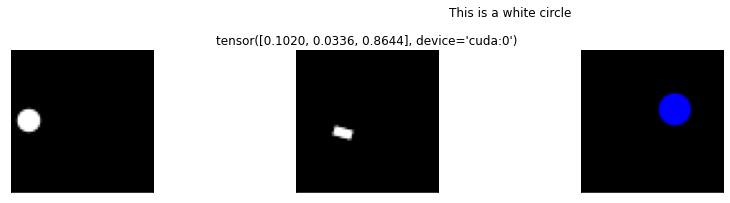

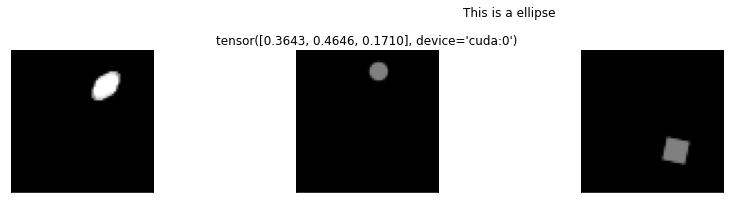

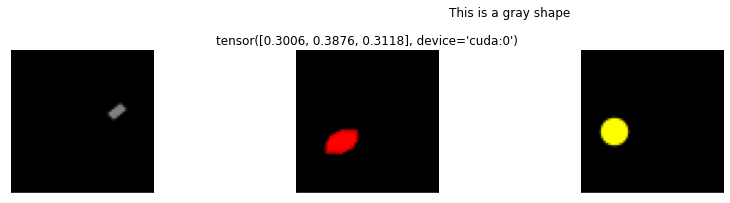

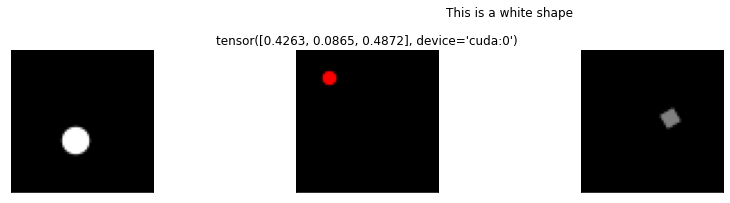

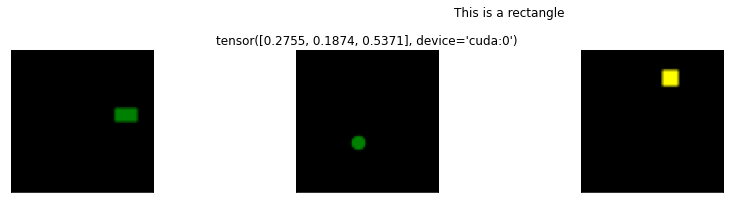

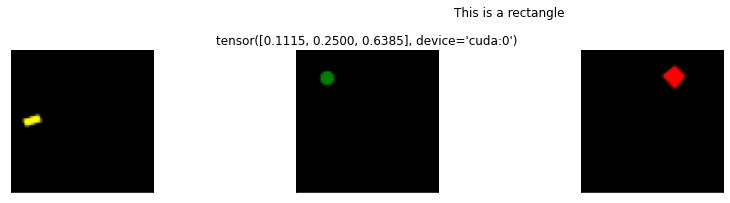

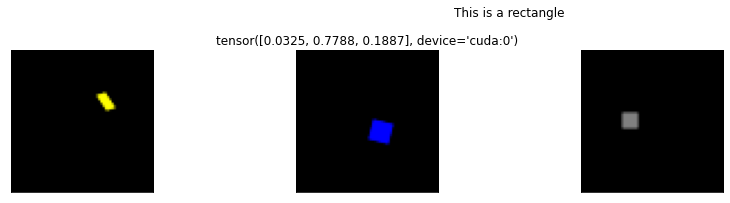

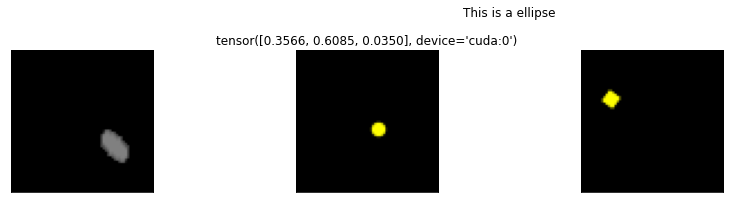

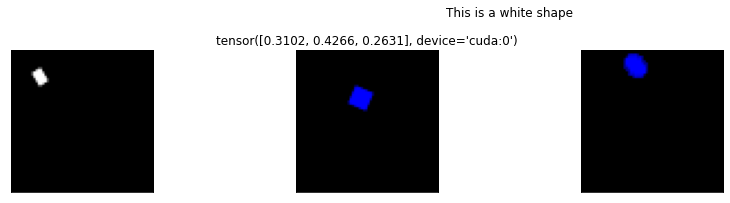

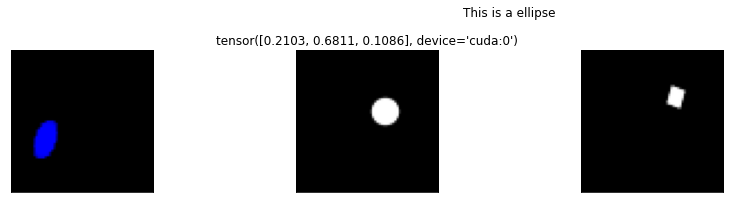

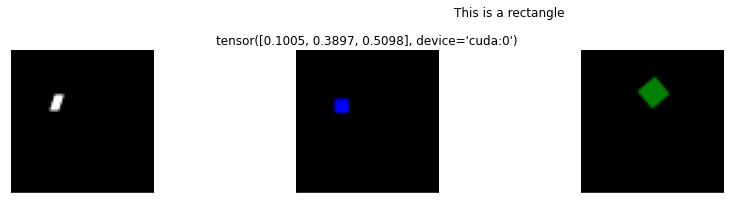

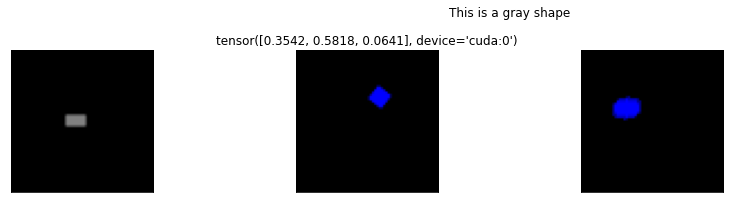

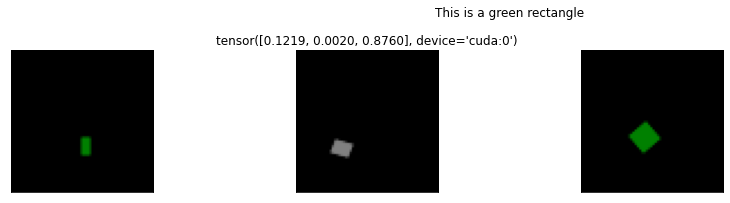

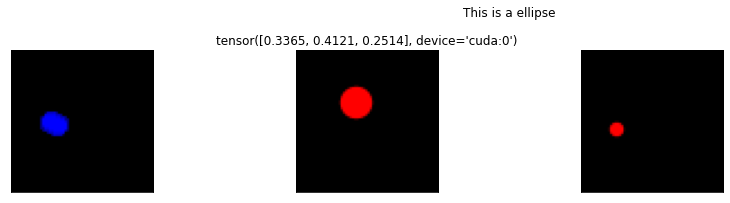

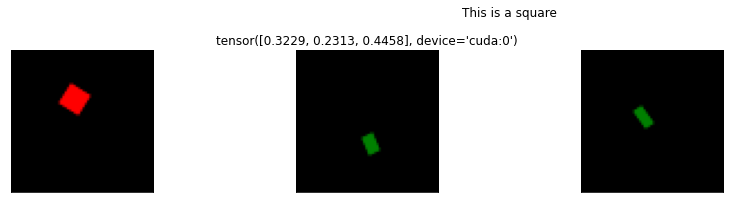

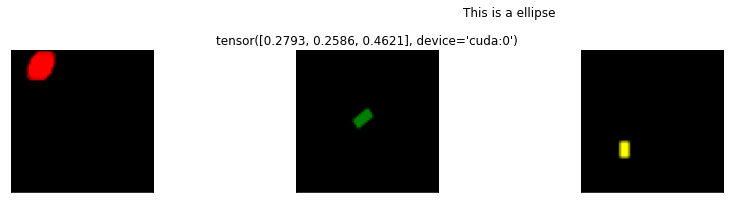

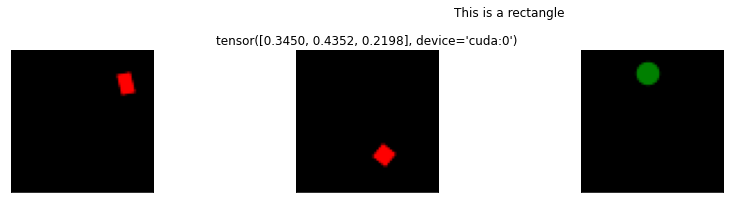

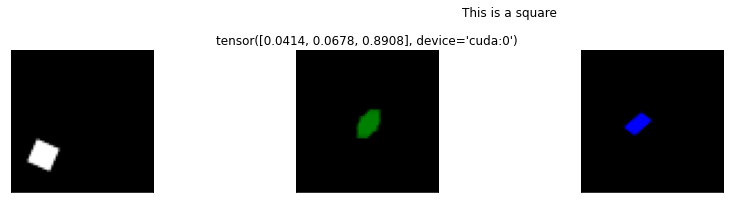

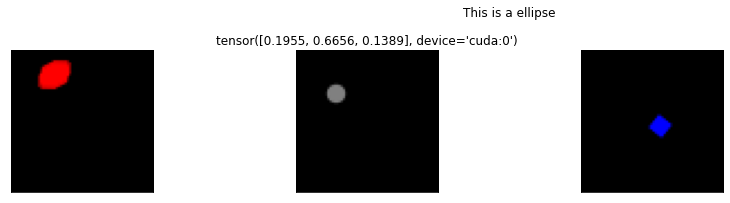

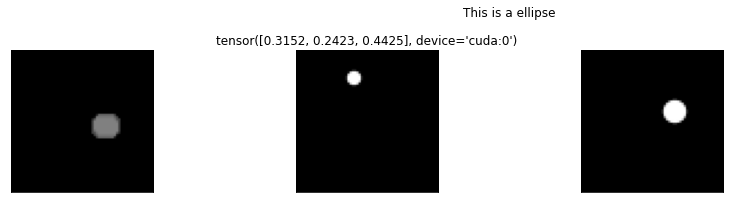

In [37]:
for i in fail_index_list:
    plt.figure(figsize=(16, 5))
    states = batch['imgs'][i]

    for j in range(3):
        image = Image.fromarray(np.uint8(states[j])).convert('RGB')
        plt.subplot(2, 4, j + 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        if j == 1:
            lang = batch['langs'][i]
            utterance = "This is a " + lang
            plt.suptitle(utterance)
            plt.title(lis_scores_final[i])
            # plt.title(entropies[i])
    
    plt.tight_layout()    

In [46]:
fail_utterance_list = []

for i in fail_index_list:
    lang = batch['langs'][i]
    utterance = "This is a " + lang
    fail_utterance_list.append(utterance)

In [47]:
fail_utterance_list

['This is a white rectangle',
 'This is a ellipse',
 'This is a rectangle',
 'This is a ellipse',
 'This is a white shape',
 'This is a rectangle',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a white circle',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a white shape',
 'This is a ellipse',
 'This is a rectangle',
 'This is a square',
 'This is a white shape',
 'This is a ellipse',
 'This is a rectangle',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a ellipse',
 'This is a square',
 'This is a white shape',
 'This is a ellipse',
 'This is a rectangle',
 'This is a rectangle',
 'This is a white shape',
 'This is a rectangle',
 'This is a square',
 'This is a ellipse',
 'This is a rectangle',
 'This is a white shape',
 'This is a ellipse',
 'This is a ellipse',
 'Th

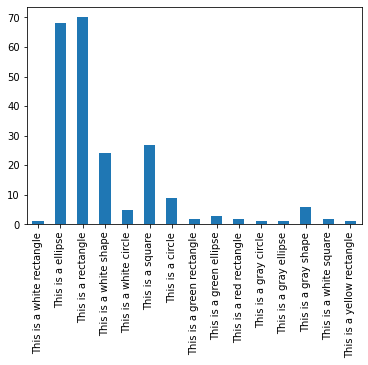

In [54]:
from collections import Counter
import pandas as pd

data = fail_utterance_list
count = Counter(data)
df1 = pd.DataFrame.from_dict(count, orient='index', columns=['fail_count'])
df1.plot(kind='bar', legend=False)
plt.savefig("fail_utterance_bargraph.png", bbox_inches='tight', dpi=300)

In [55]:
df1

,fail_count
This is a white rectangle,1
This is a ellipse,68
This is a rectangle,70
This is a white shape,24
This is a white circle,5
This is a square,27
This is a circle,9
This is a green rectangle,2
This is a green ellipse,3
This is a red rectangle,2


In [56]:
utterance_list = []
for i in range(len(imgs)):
    lang = batch['langs'][i]
    utterance = "This is a " + lang
    utterance_list.append(utterance)

In [57]:
data = utterance_list
count = Counter(data)
df2 = pd.DataFrame.from_dict(count, orient='index', columns=['total_count'])

In [58]:
df2

,total_count
This is a yellow shape,47
This is a red shape,59
This is a gray shape,69
This is a green shape,64
This is a white shape,79
This is a circle,125
This is a rectangle,146
This is a white square,6
This is a white rectangle,1
This is a blue shape,66


In [61]:
df = pd.concat([df1, df2], axis=1)
df['fail_count'] = df['fail_count'].fillna(0)
df['fail_ratio'] = df['fail_count'] / df['total_count']
df

,fail_count,total_count,fail_ratio
This is a white rectangle,1.0,1,1.000000
This is a ellipse,68.0,136,0.500000
This is a rectangle,70.0,146,0.479452
This is a white shape,24.0,79,0.303797
This is a white circle,5.0,6,0.833333
This is a square,27.0,144,0.187500
This is a circle,9.0,125,0.072000
This is a green rectangle,2.0,4,0.500000
This is a green ellipse,3.0,5,0.600000
This is a red rectangle,2.0,3,0.666667


In [62]:
import seaborn as sns

In [67]:
df = df.reset_index()

In [68]:
df

,index,fail_count,total_count,fail_ratio
0,This is a white rectangle,1.0,1,1.000000
1,This is a ellipse,68.0,136,0.500000
2,This is a rectangle,70.0,146,0.479452
3,This is a white shape,24.0,79,0.303797
4,This is a white circle,5.0,6,0.833333
5,This is a square,27.0,144,0.187500
6,This is a circle,9.0,125,0.072000
7,This is a green rectangle,2.0,4,0.500000
8,This is a green ellipse,3.0,5,0.600000
9,This is a red rectangle,2.0,3,0.666667


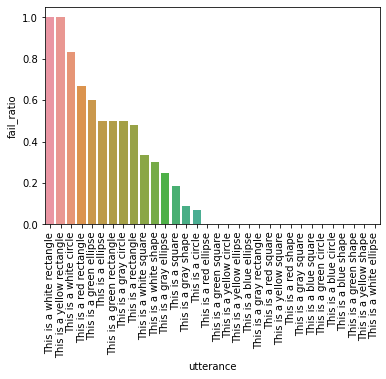

In [81]:
sns.barplot(x = 'index', y='fail_ratio', data=df.sort_values('fail_ratio', ascending=False))
plt.xlabel("utterance")
plt.xticks(rotation=90)
plt.savefig("utterance_failratio_bargraph.png", bbox_inches='tight', dpi=300)
plt.show()